In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [2]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [3]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [4]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# sum of cases each year
cases_sum = df.groupby(['year'])['cases'].sum().reset_index()

print(cases_sum)

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    year   cases
0   2012  254010
1   2013  256911
2   2014   15150
3   2015   94824
4   2016  112646
5   2017   17257
6   2018   25184
7   2019   50378
8   2020    8021
9   2021    5445
10  2022   23100


In [5]:
selected_columns = ['week', 'city', 'cases', 'cases_per_100k', 'temp_avg', 'humidity_avg',
                    'precipitation_avg_ordinary_kriging', 'vim',
                'month_sin', 'month_cos', 'week_sin', 'week_cos']

df = df[selected_columns]

In [6]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0, 1])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['temp_avg', 'humidity_avg', 'precipitation_avg_ordinary_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[3, 4])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='city', target_col='cases', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [7]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min', 'cases_per_100k',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                   'nearby_cases_weighted']
lagged_vars = [col for col in data.columns if '_lag' in col]

# Filter scaler_vars to only include variables that are in data.columns
scaler_vars = [col for col in continuous_vars + lagged_vars if col in data.columns]

In [8]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202053)]
test_data = data[(data['week'] > 202053)]

# Create a copy of test_data for future reference (preserves 'city' and 'week')
X_test_original = test_data.copy()

# Reset index of test_data to start from 0
test_data = test_data.reset_index(drop=True)

# Extract city-wise indices before dropping the 'city' column
city_index_map = {}
for city in test_data['city'].unique():
    print(f"City: {city}")
    print(test_data[test_data['city'] == city]['cases'][:25])
    city_index_map[city] = test_data[test_data['city'] == city].index 

# Columns to exclude when training the model
columns_exclude = ['cases', 'city']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['cases']

X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
print(X_test.head(25)['cases_lag0'])
y_test = test_data['cases']

X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])

# scale target
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

City: angra dos reis
0      0.0
1      0.0
2      1.0
3      3.0
4      0.0
5      0.0
6      1.0
7      0.0
8      3.0
9      2.0
10     5.0
11    10.0
12     2.0
13     4.0
14     4.0
15     3.0
16     3.0
17     4.0
18     2.0
19     6.0
20     2.0
21     1.0
22     5.0
23     1.0
24     3.0
Name: cases, dtype: float64
City: aperibé
102    0.0
103    0.0
104    0.0
105    0.0
106    0.0
107    0.0
108    1.0
109    0.0
110    0.0
111    0.0
112    0.0
113    0.0
114    0.0
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
120    0.0
121    0.0
122    0.0
123    0.0
124    0.0
125    0.0
126    0.0
Name: cases, dtype: float64
City: araruama
204    1.0
205    1.0
206    1.0
207    2.0
208    0.0
209    0.0
210    1.0
211    1.0
212    0.0
213    1.0
214    1.0
215    0.0
216    0.0
217    0.0
218    0.0
219    1.0
220    1.0
221    0.0
222    0.0
223    1.0
224    0.0
225    0.0
226    0.0
227    1.0
228    1.0
Name: cases, dtype: float64
City: areal
306    0.0
307    0.0
308    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18620\3699312056.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.0716286   0.0845864   0.07594787 ... -0.08386507 -0.07522653
 -0.08386507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18620\3699312056.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.0795458  -0.08386507 -0.08386507 ... -0.0795458  -0.08386507
 -0.07522653]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


In [9]:
# X_train = X_train.copy()
# X_test = X_test.copy()
# 
# # Properly convert city to category
# X_train['city'] = X_train['city'].astype('category')
# X_test['city'] = X_test['city'].astype('category')
# 
# # Create LGBM dataset and explicitly declare 'city' as categorical
# train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=['city'])
# test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [10]:
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [11]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Remove negative predictions
y_pred = np.clip(y_pred, 0, None)

# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test)

# Step 10: Save the model
model.save_model('lightgbm_dengue_model.txt')

C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.32098	valid_1's rmse: 0.0252975
Early stopping, best iteration is:
[81]	training's rmse: 0.374283	valid_1's rmse: 0.0252511


Top 10 Most Important Features:
                                    Feature  Importance
10                               cases_lag0         483
11                               cases_lag1         293
0                                      week         211
1                            cases_per_100k         183
5                                       vim         167
7                                 month_cos         134
8                                  week_sin         128
2                                  temp_avg         124
9                                  week_cos         104
16  precipitation_avg_ordinary_kriging_lag3          89


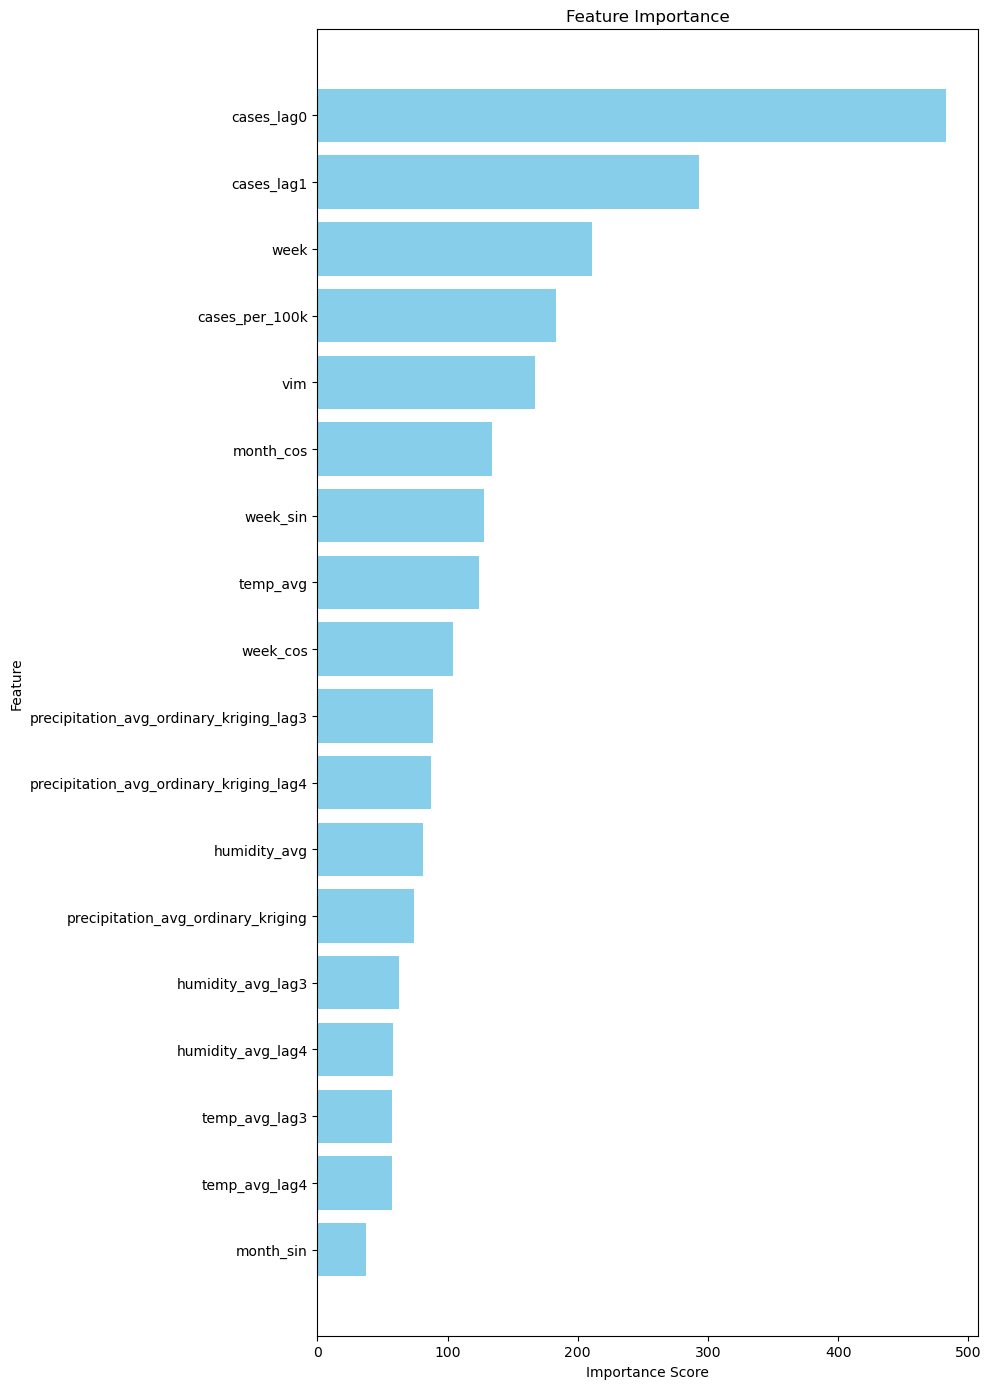

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

RMSE: 5.830506407555804


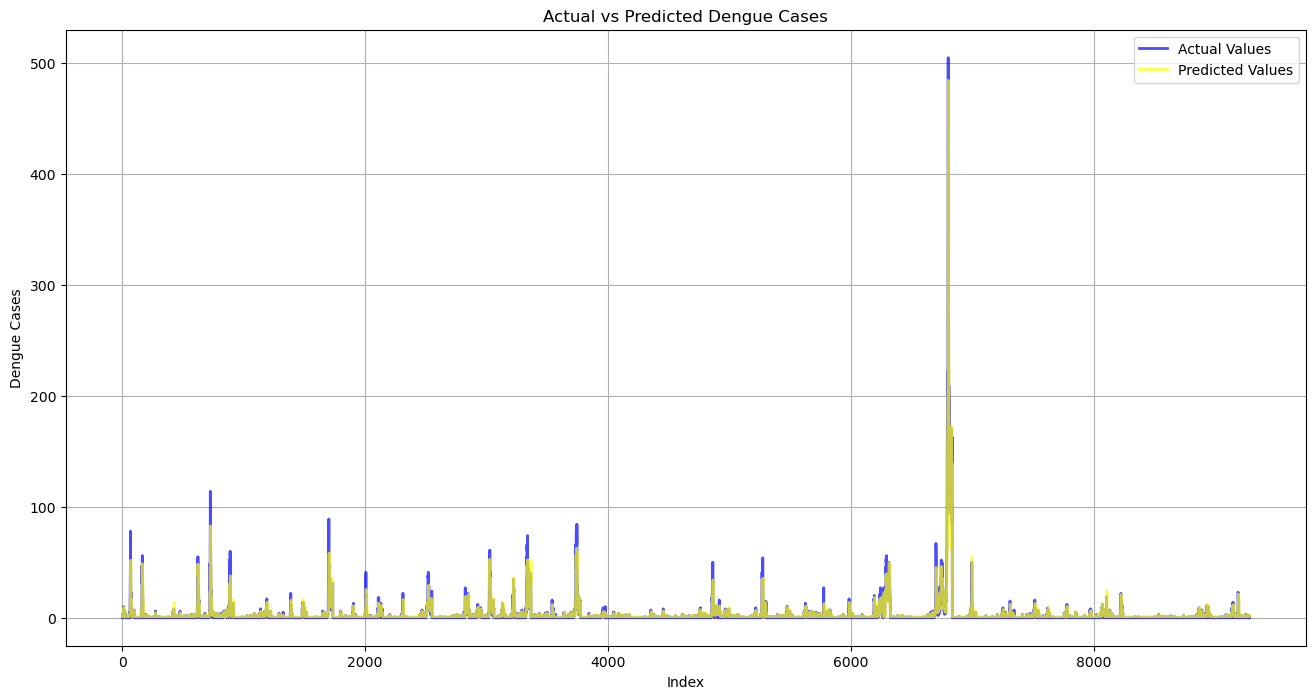

In [13]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: Get predictions on training set if not already done
train_scaled_predictions = model.predict(X_train, num_iteration=model.best_iteration)
y_train_pred = target_scaler.inverse_transform(train_scaled_predictions.reshape(-1, 1))
y_train_pred = np.clip(y_train_pred, 0, None)
y_train = target_scaler.inverse_transform(y_train)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
test_mae = mean_absolute_error(y_actual, y_pred)
test_r2 = r2_score(y_actual, y_pred)

# ===== Create Evaluation Summary Table =====
evaluation_results = {
    '': ['Global - Train', 'Global - Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae],
    'R²': [train_r2, test_r2]
}

results_df = pd.DataFrame(evaluation_results)
print("\n===== Evaluation Metrics Table =====")
print(results_df.to_string(index=False))


===== Evaluation Metrics Table =====
                    RMSE      MAE       R²
Global - Train 86.411673 6.826828 0.859947
 Global - Test  5.830506 1.949577 0.861068



City: angra dos reis, RMSE: 8.100973527345754


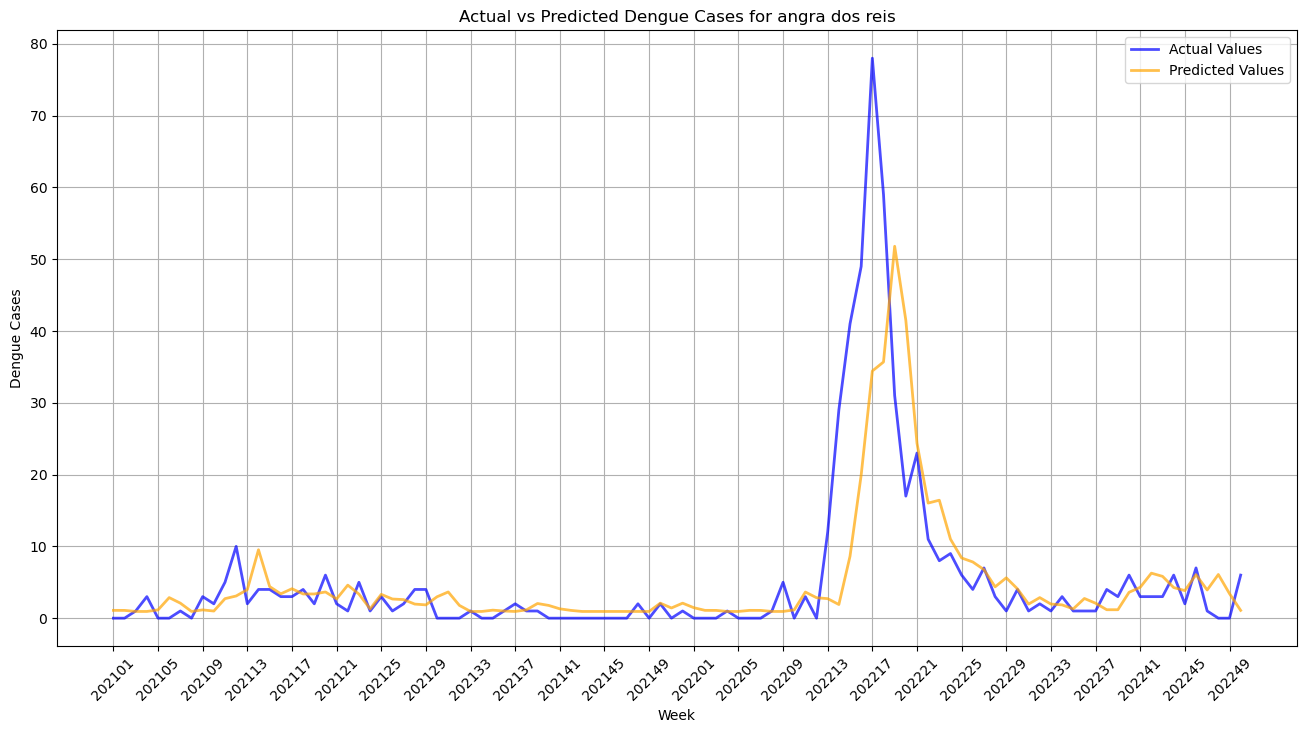


City: aperibé, RMSE: 5.568103770409744


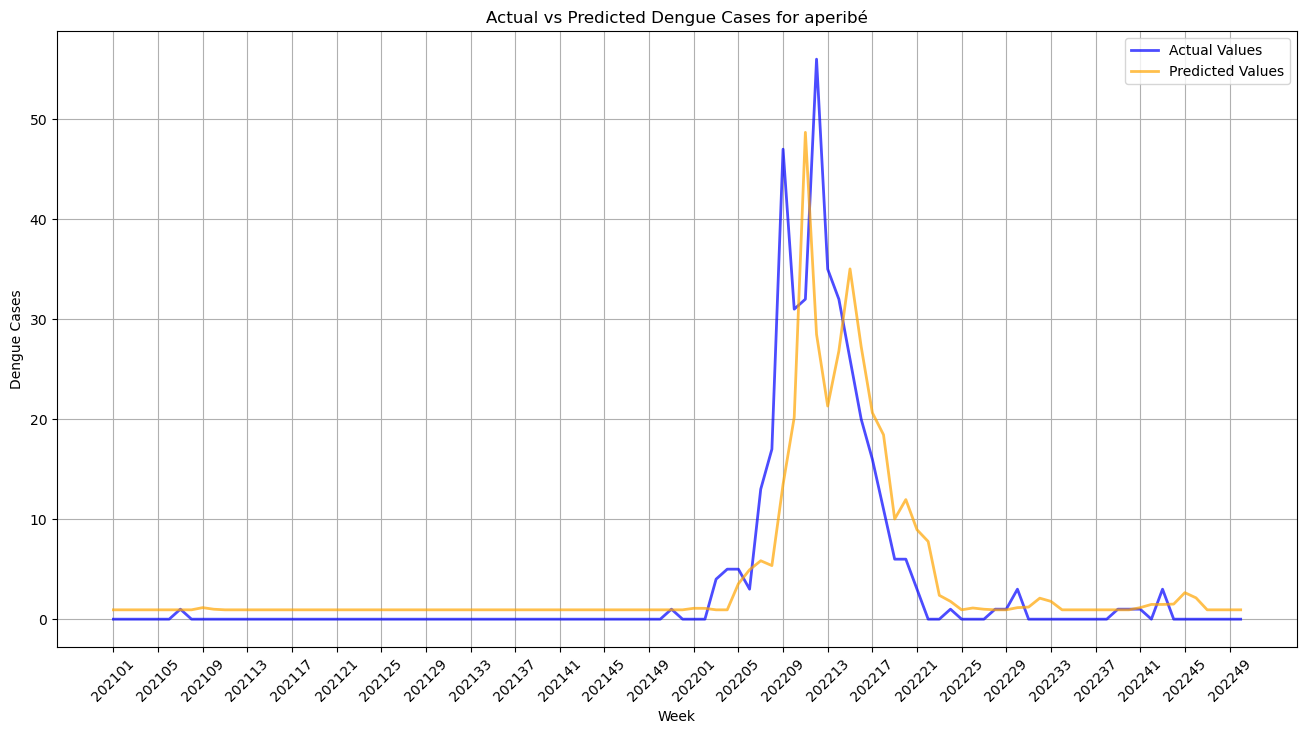


City: barra do piraí, RMSE: 5.4121322767663615


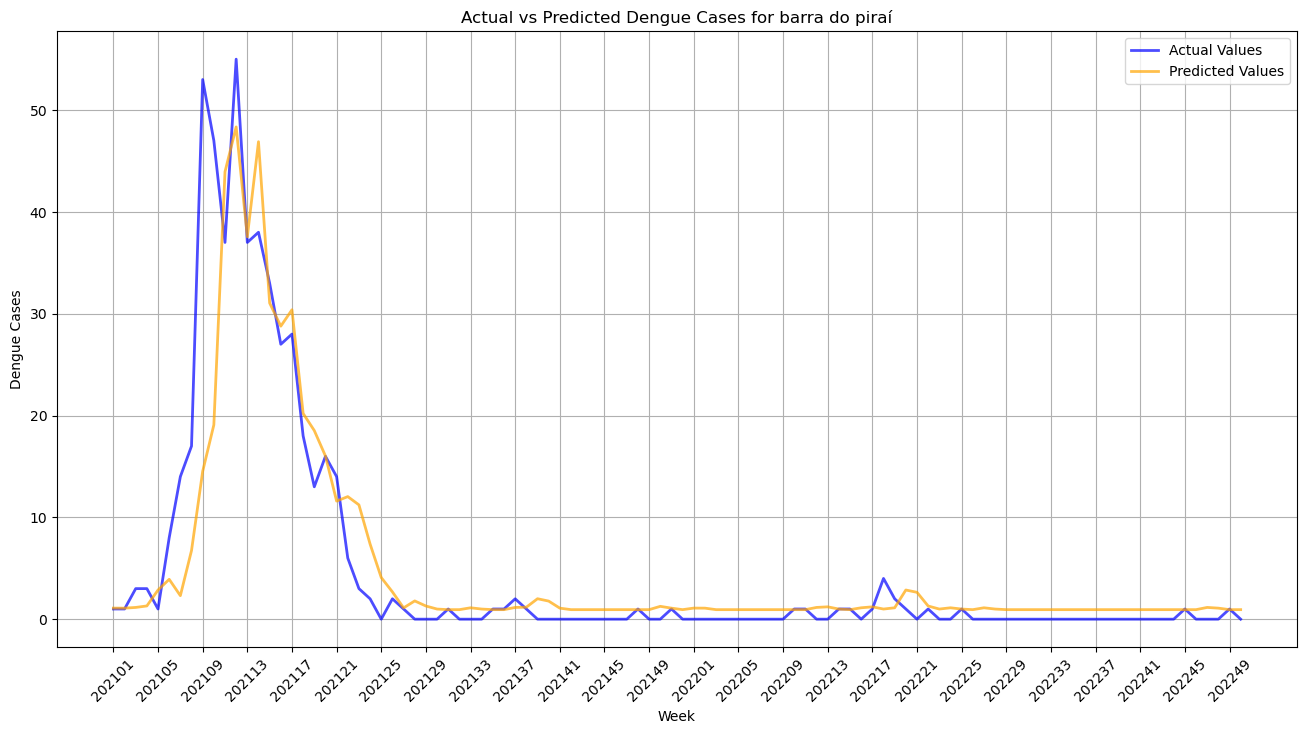


City: barra mansa, RMSE: 10.992772077935681


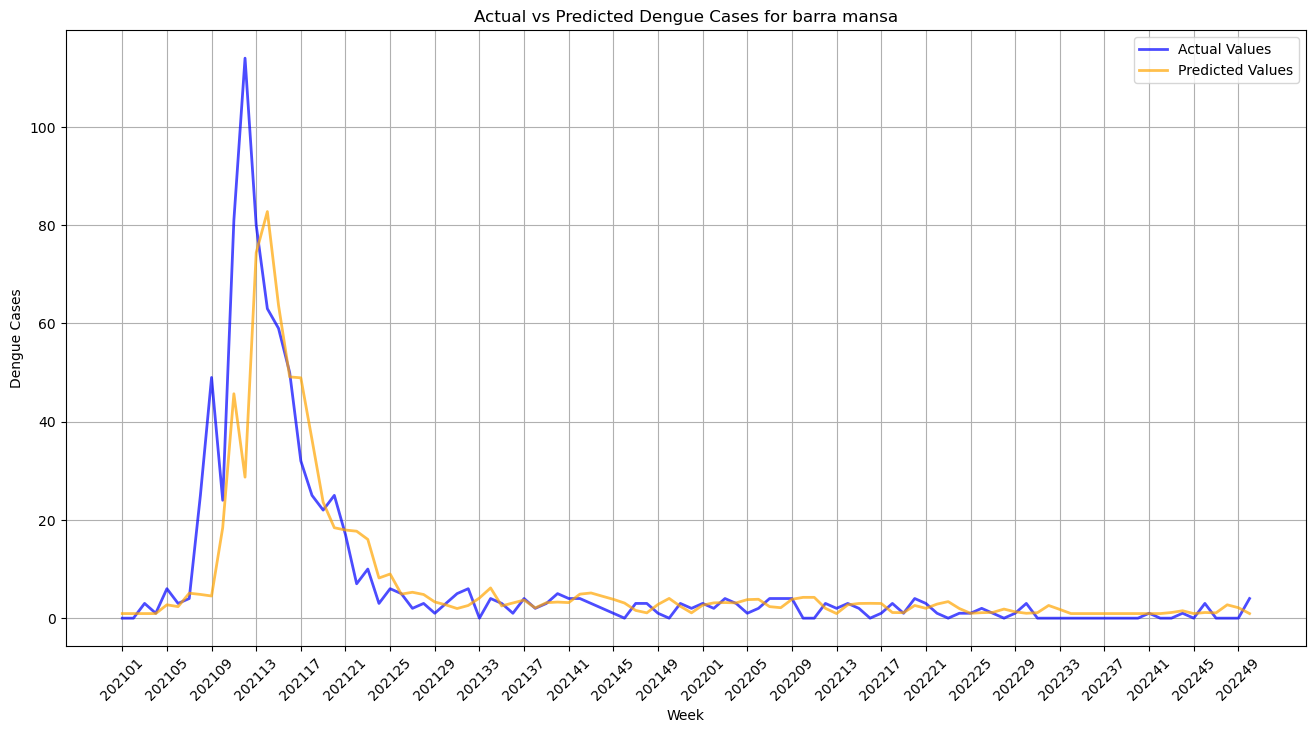


City: belford roxo, RMSE: 7.336228548461573


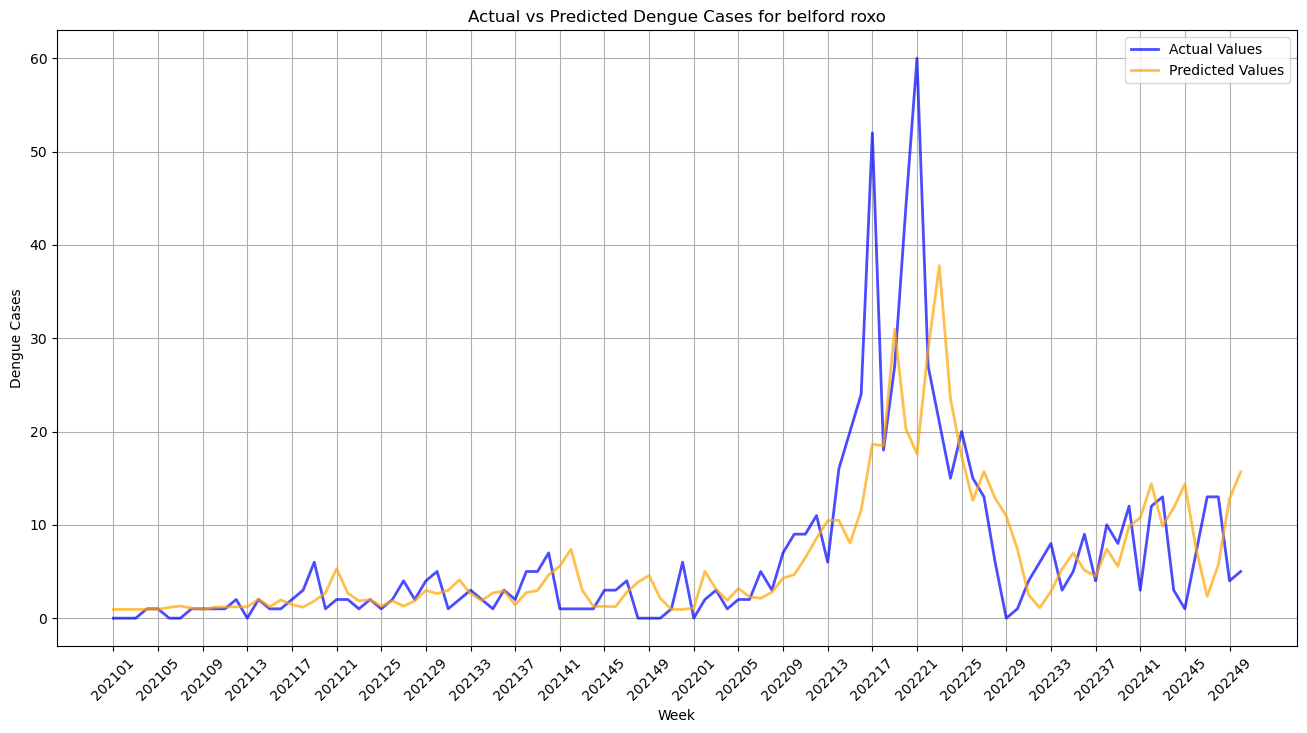


City: cabo frio, RMSE: 2.1599644643782563


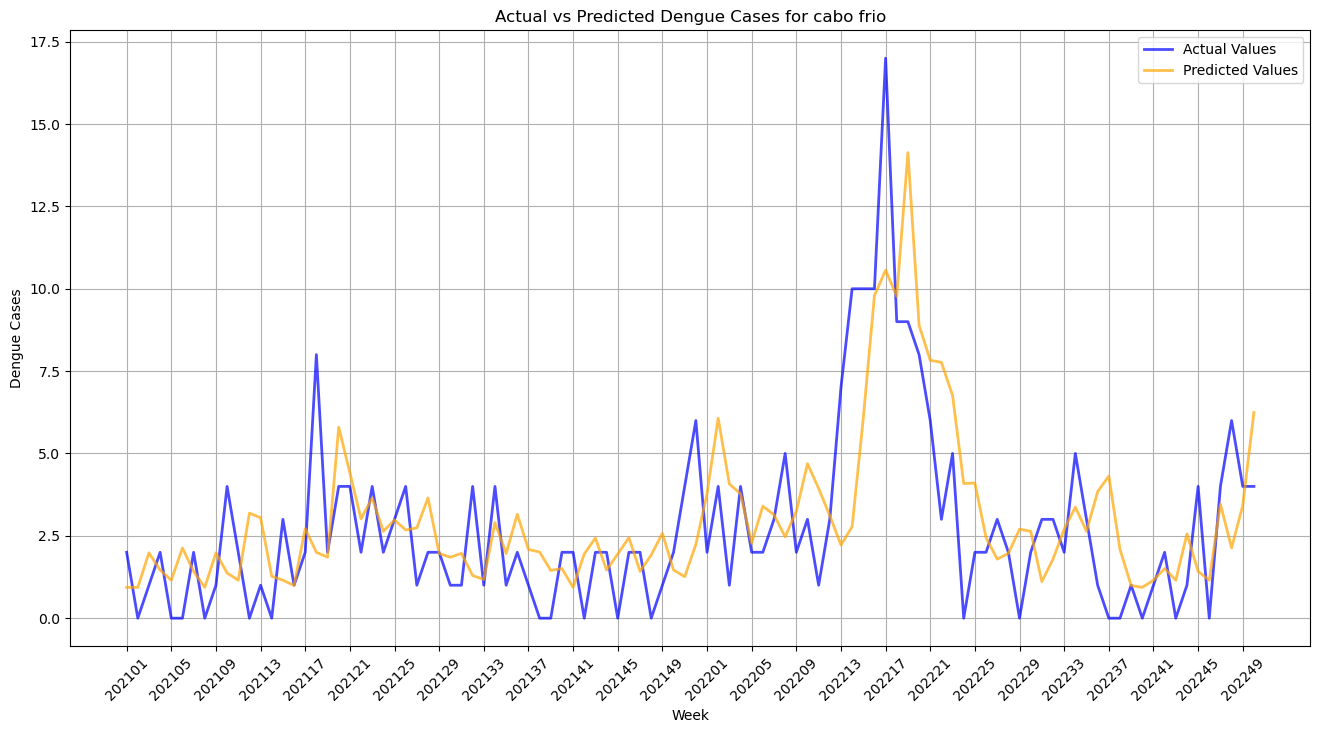


City: cambuci, RMSE: 2.7632822984358647


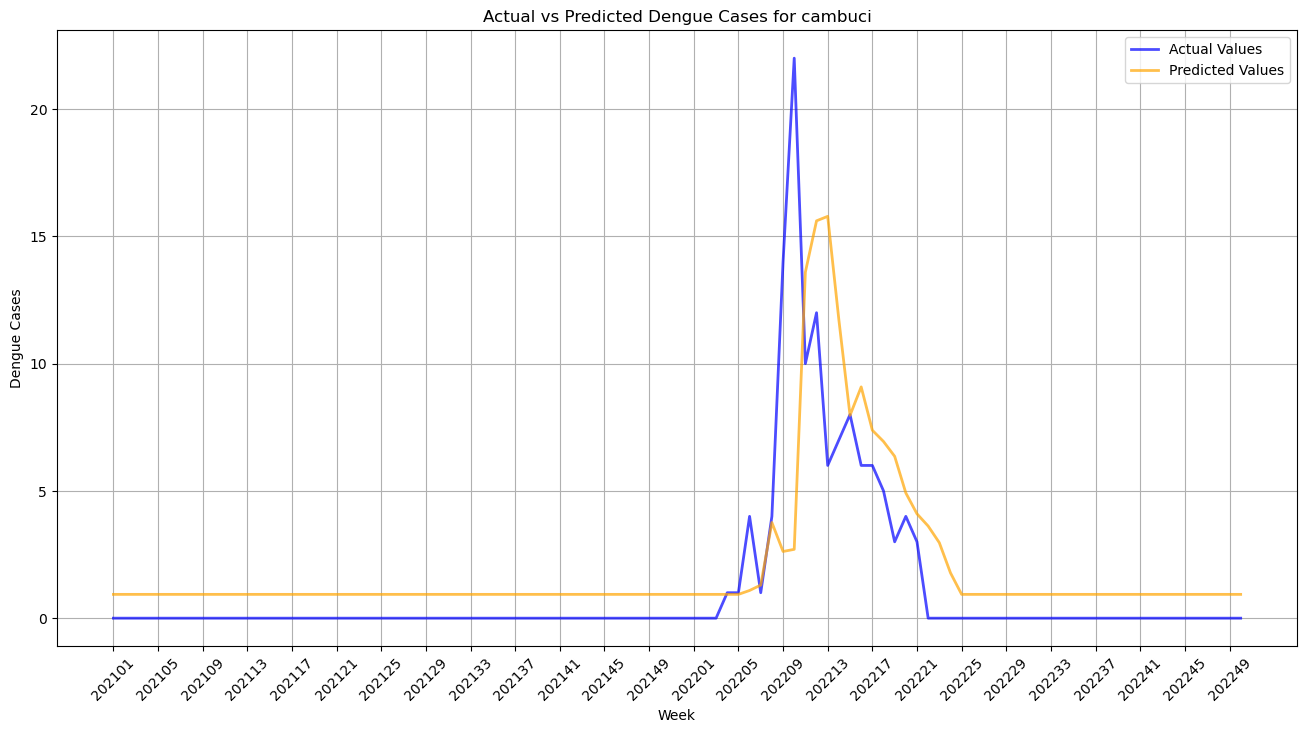


City: carapebus, RMSE: 2.554154817719426


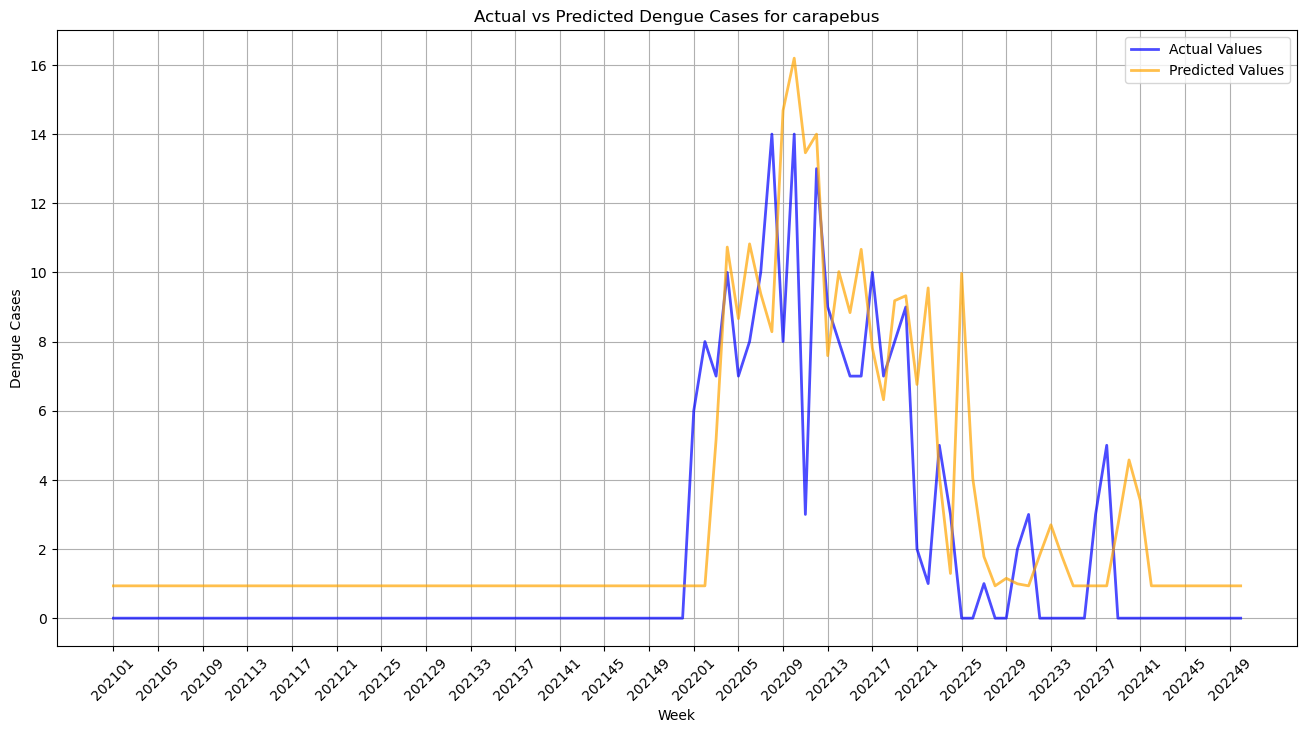


City: campos dos goytacazes, RMSE: 9.725690798086646


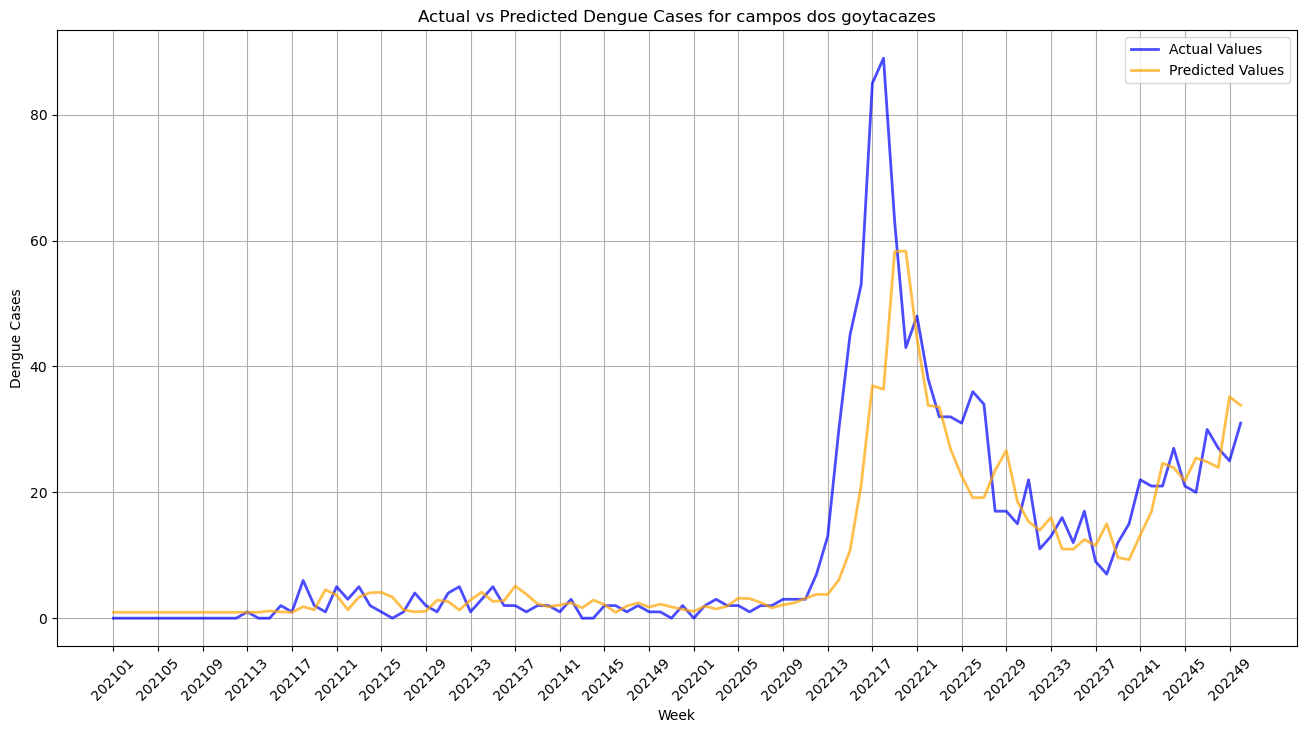


City: cardoso moreira, RMSE: 1.917507518100412


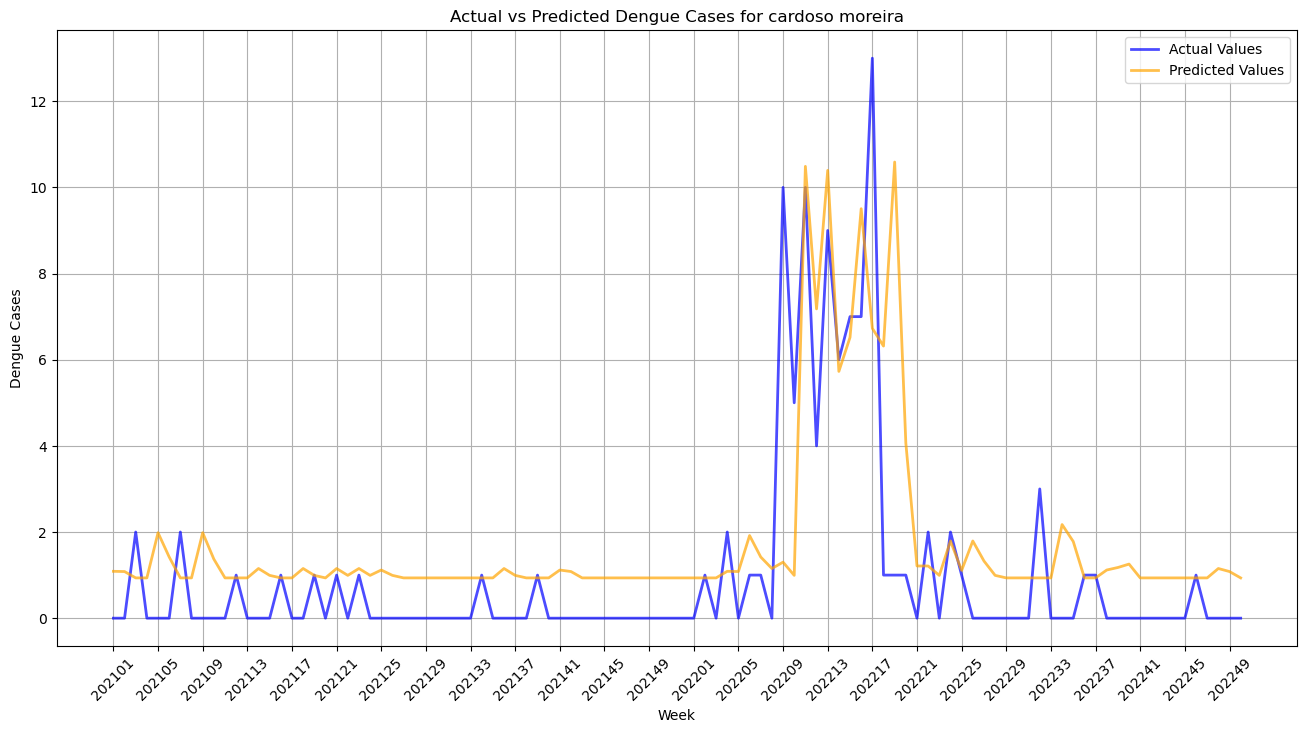


City: carmo, RMSE: 4.267392849617321


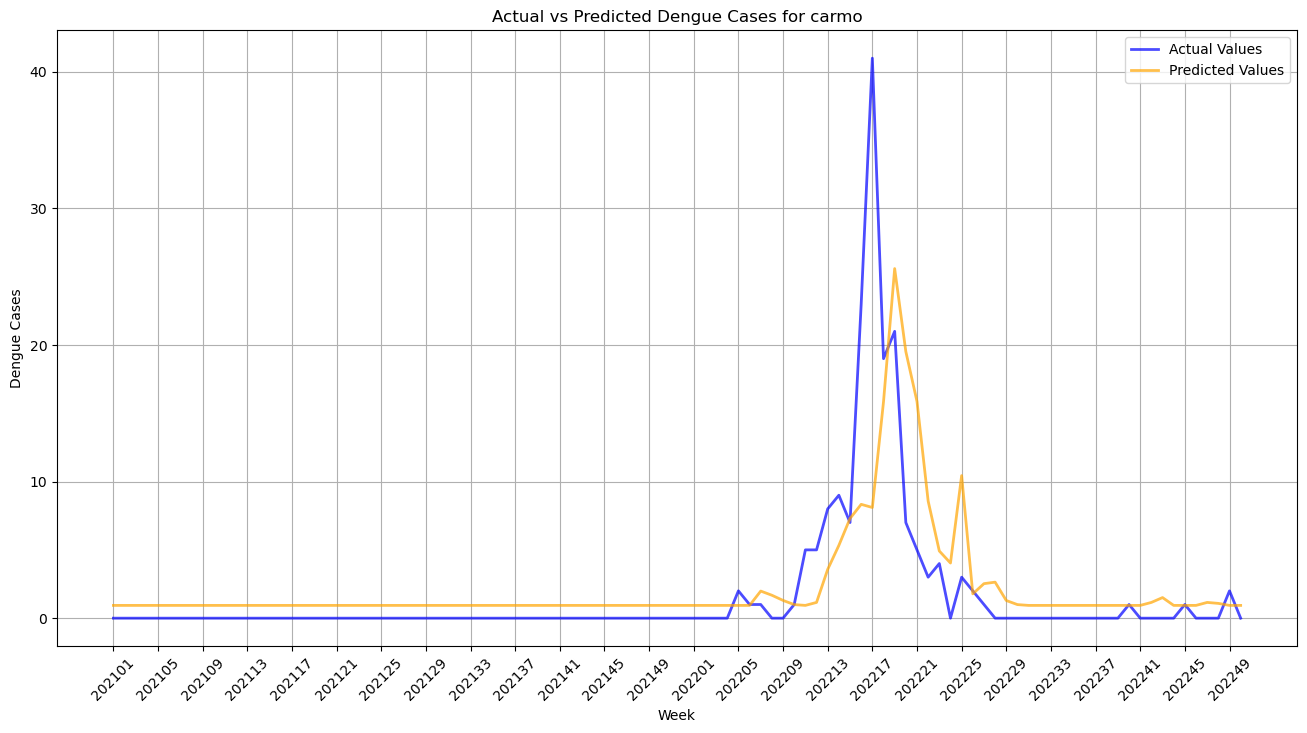


City: casimiro de abreu, RMSE: 3.0219570527150212


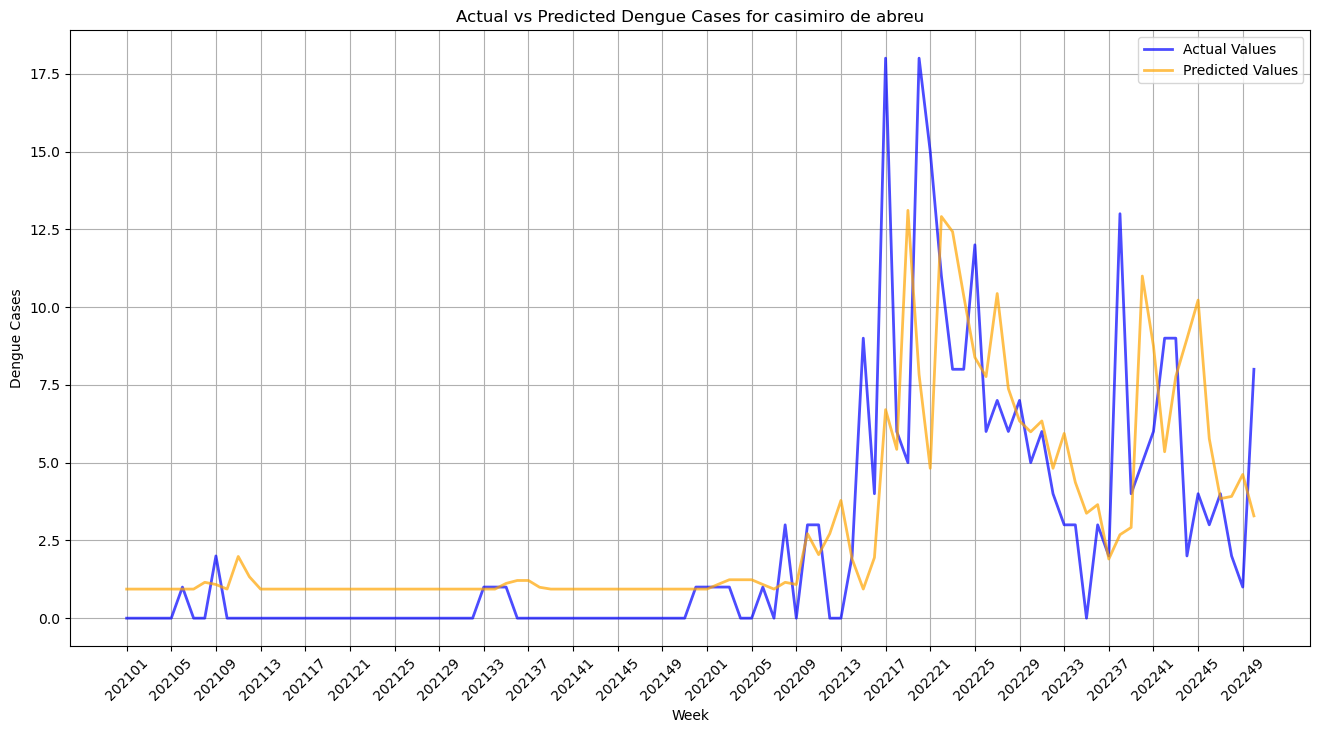


City: cordeiro, RMSE: 2.2562070730785573


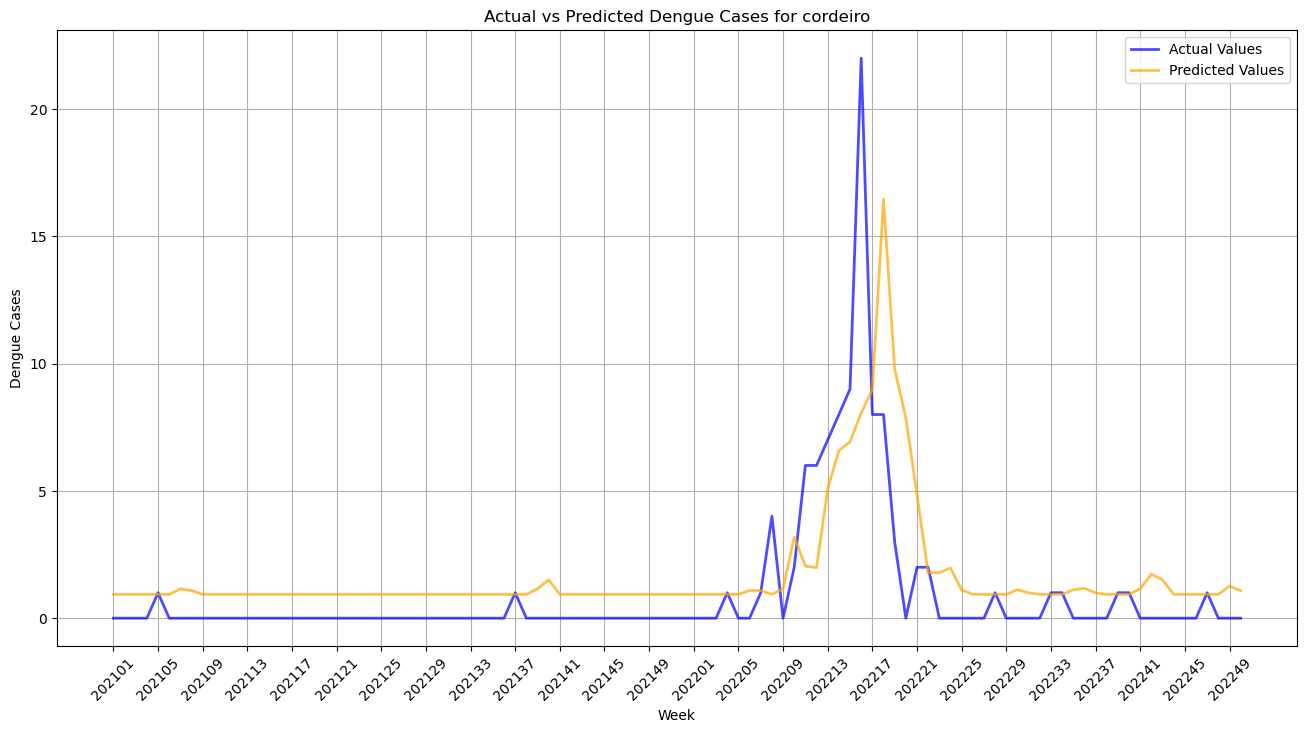


City: duque de caxias, RMSE: 5.07533337803816


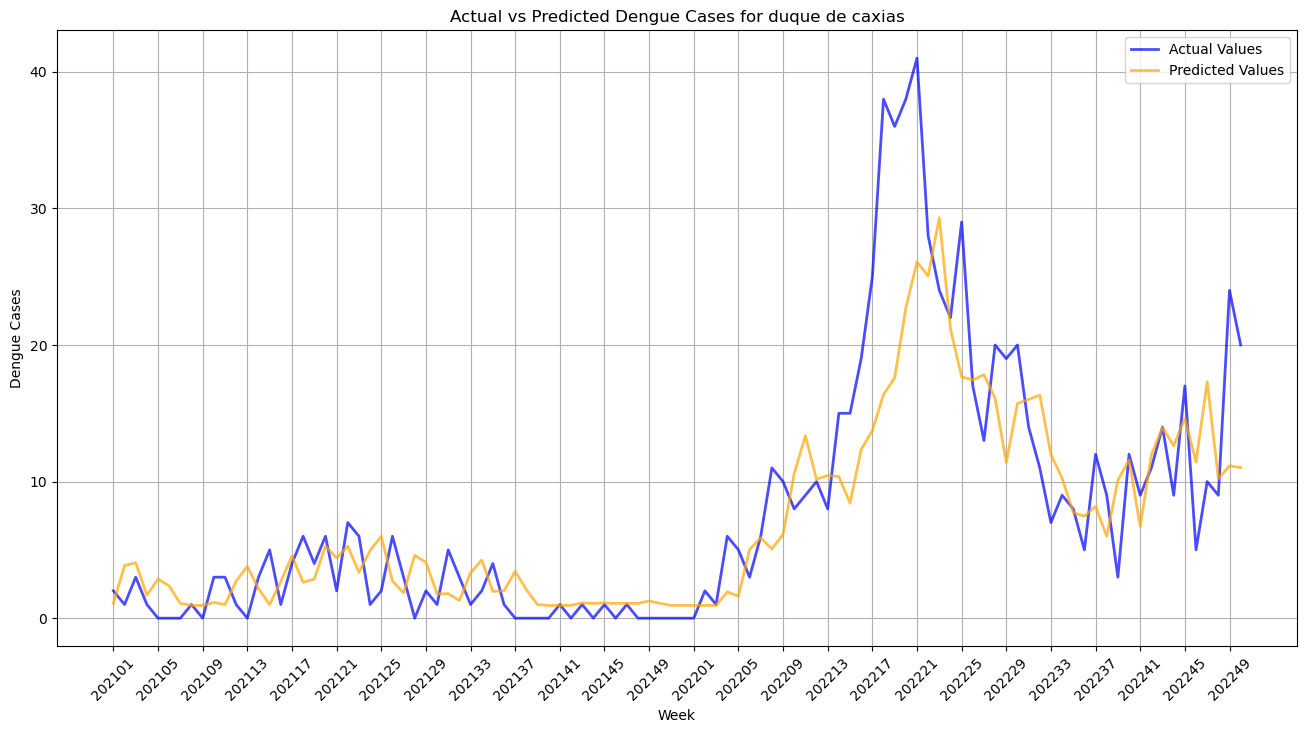


City: iguaba grande, RMSE: 4.940539797298556


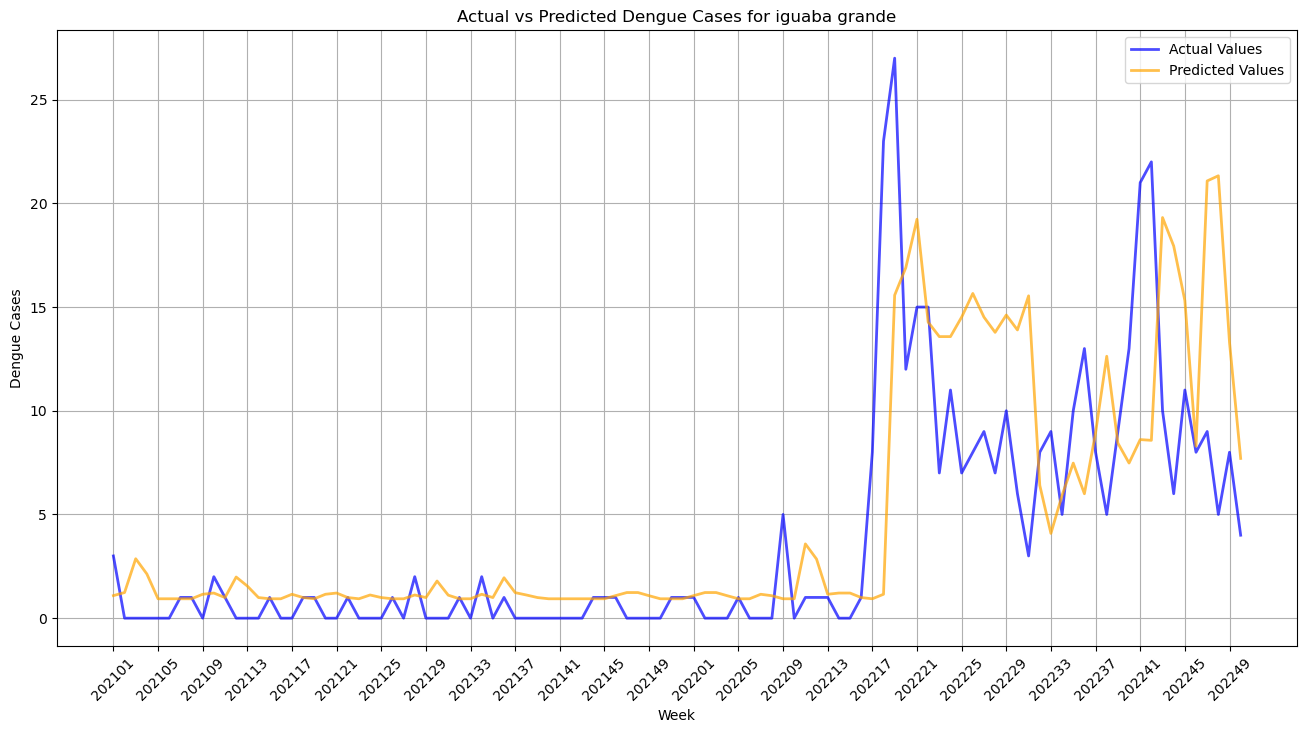


City: itaboraí, RMSE: 2.277471753106533


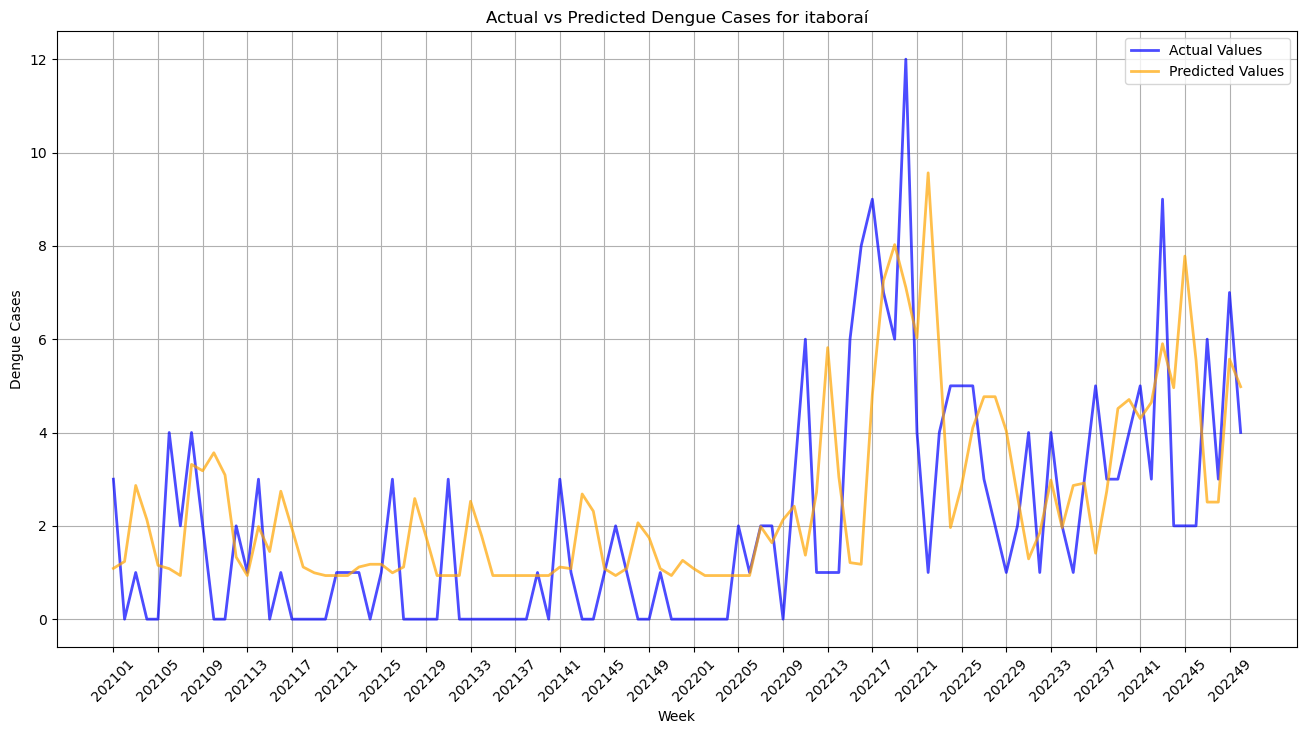


City: itaguaí, RMSE: 5.681723431644938


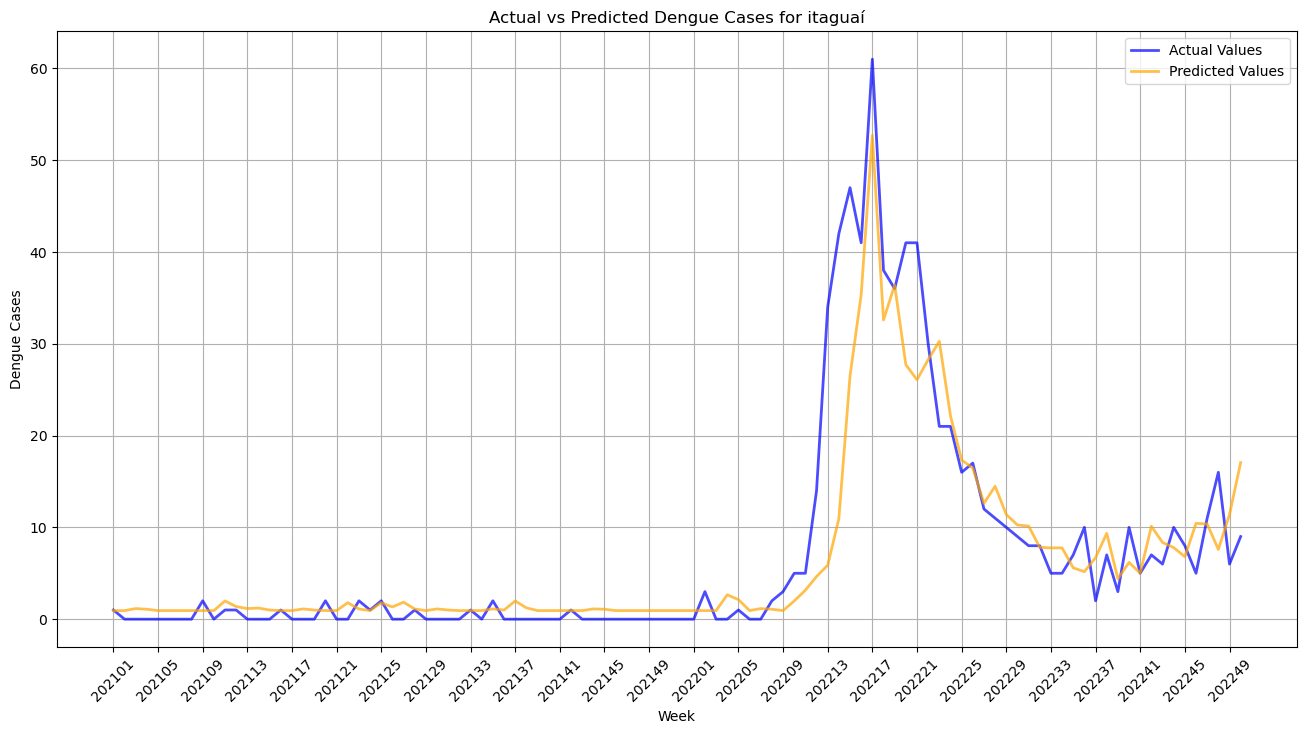


City: italva, RMSE: 2.5639073141871633


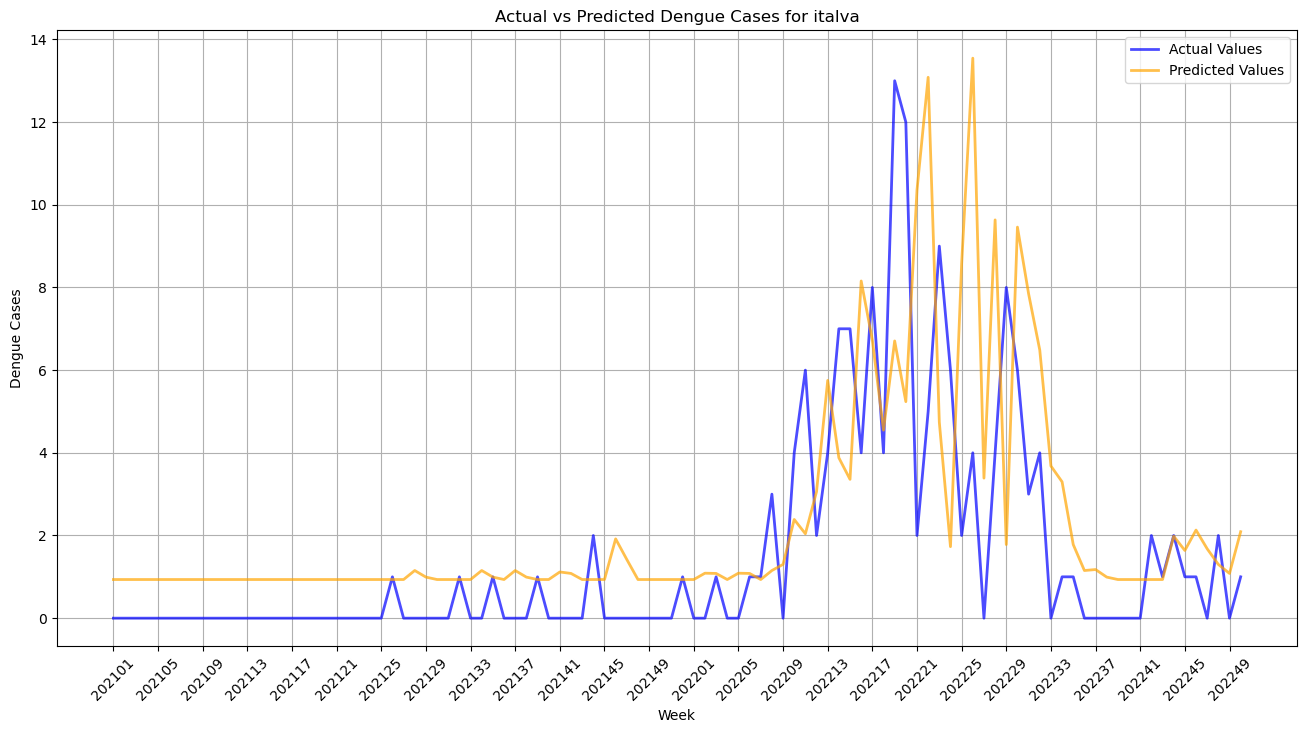


City: itaocara, RMSE: 4.540716923109033


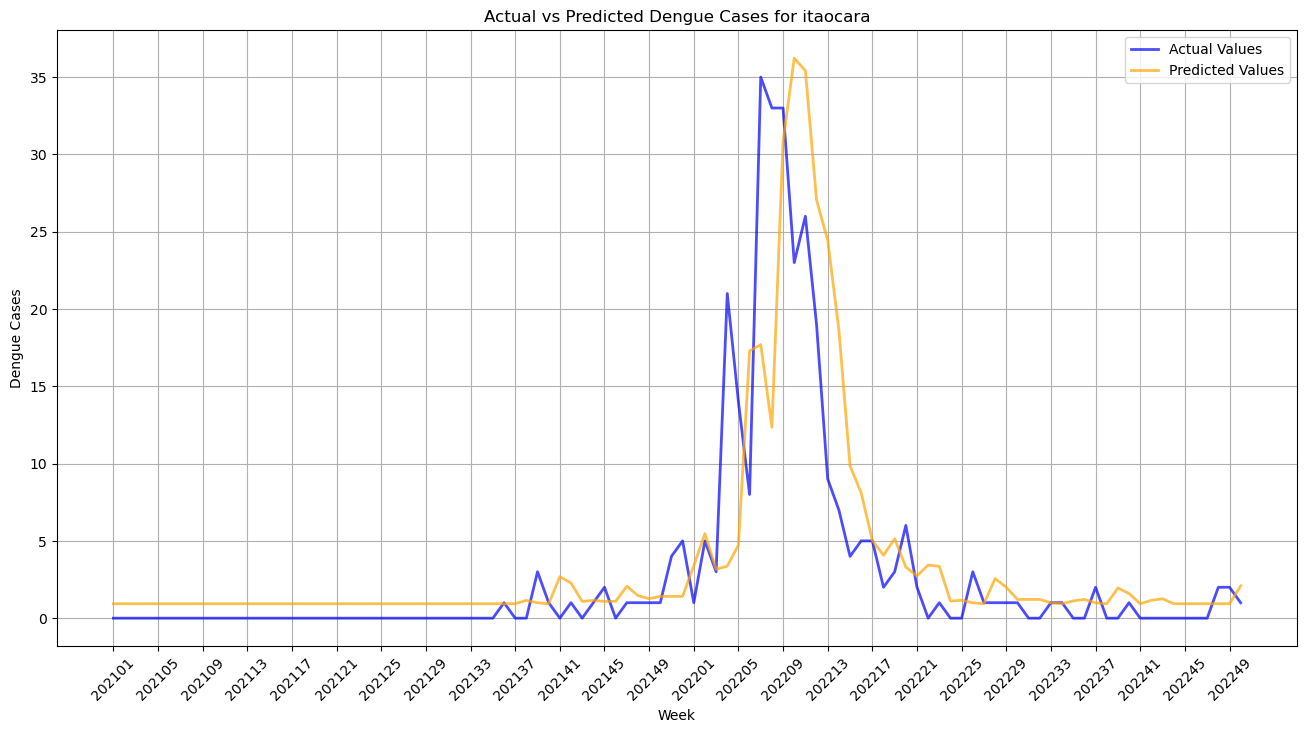


City: itaperuna, RMSE: 9.241845859354456


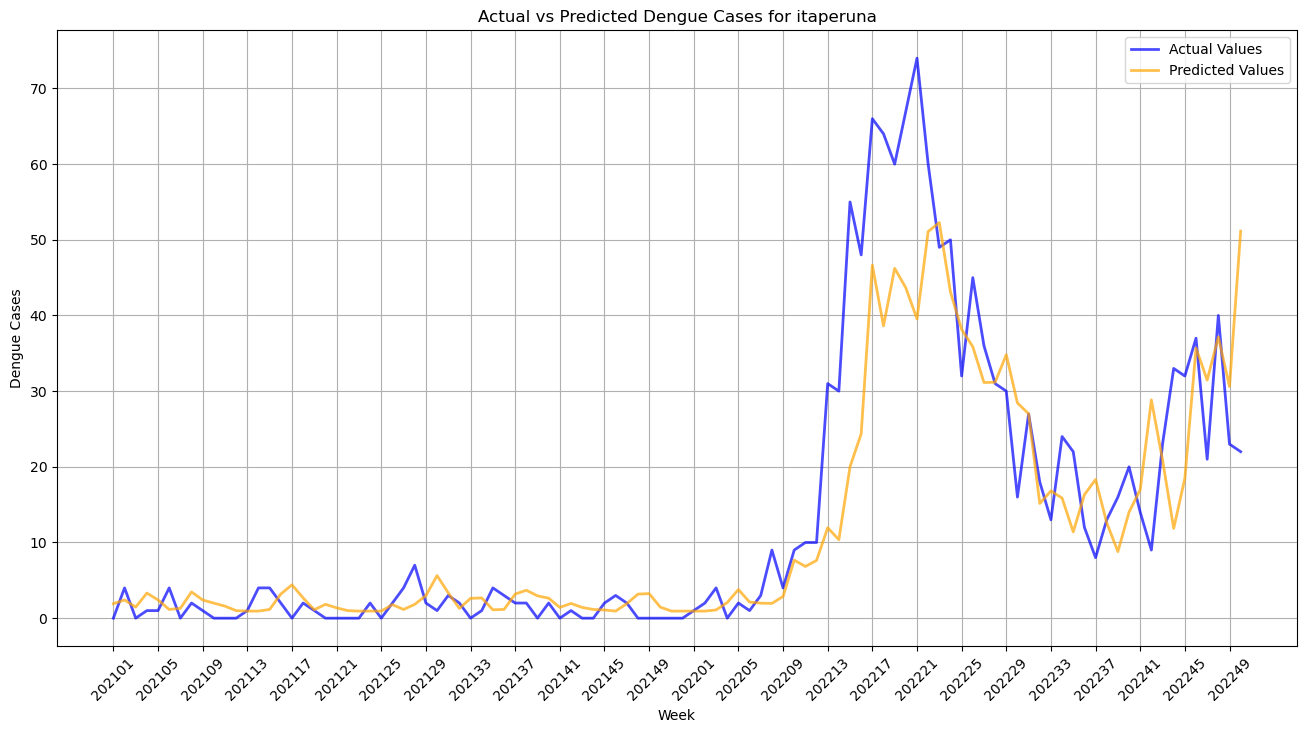


City: japeri, RMSE: 2.48219106098856


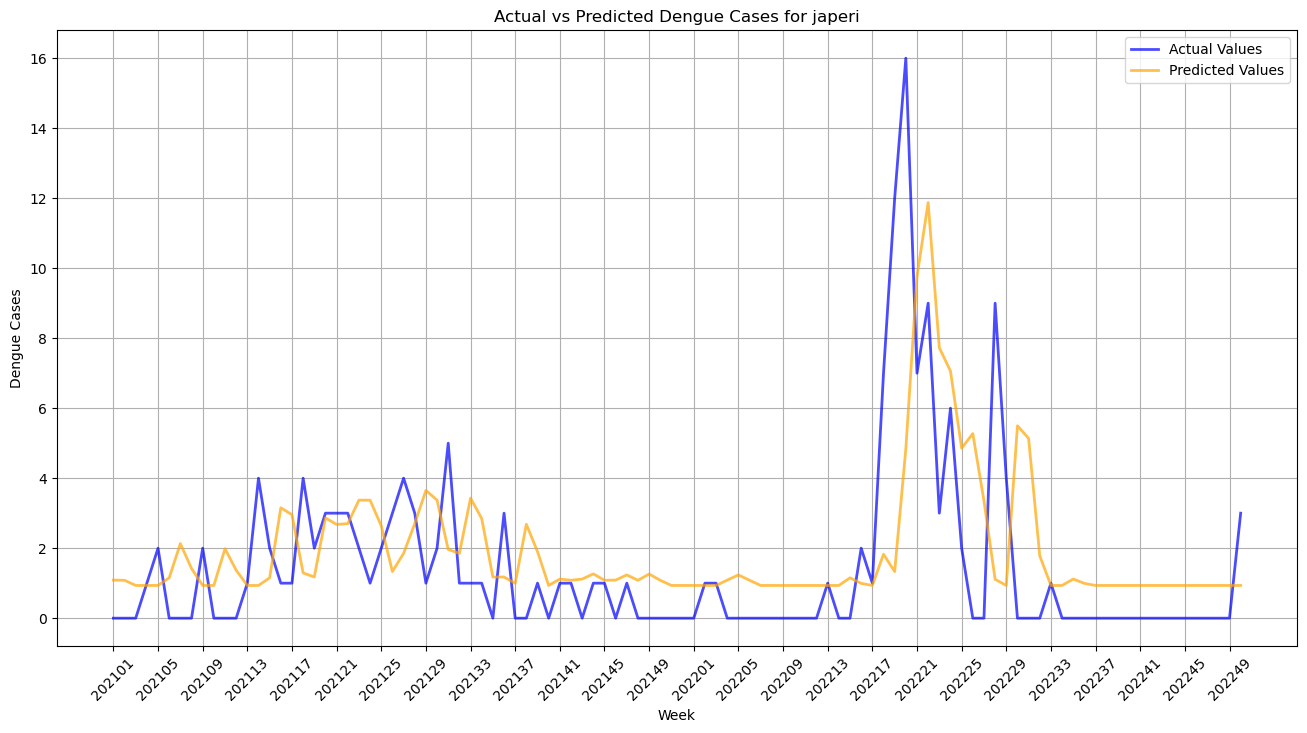


City: macaé, RMSE: 10.23664862111923


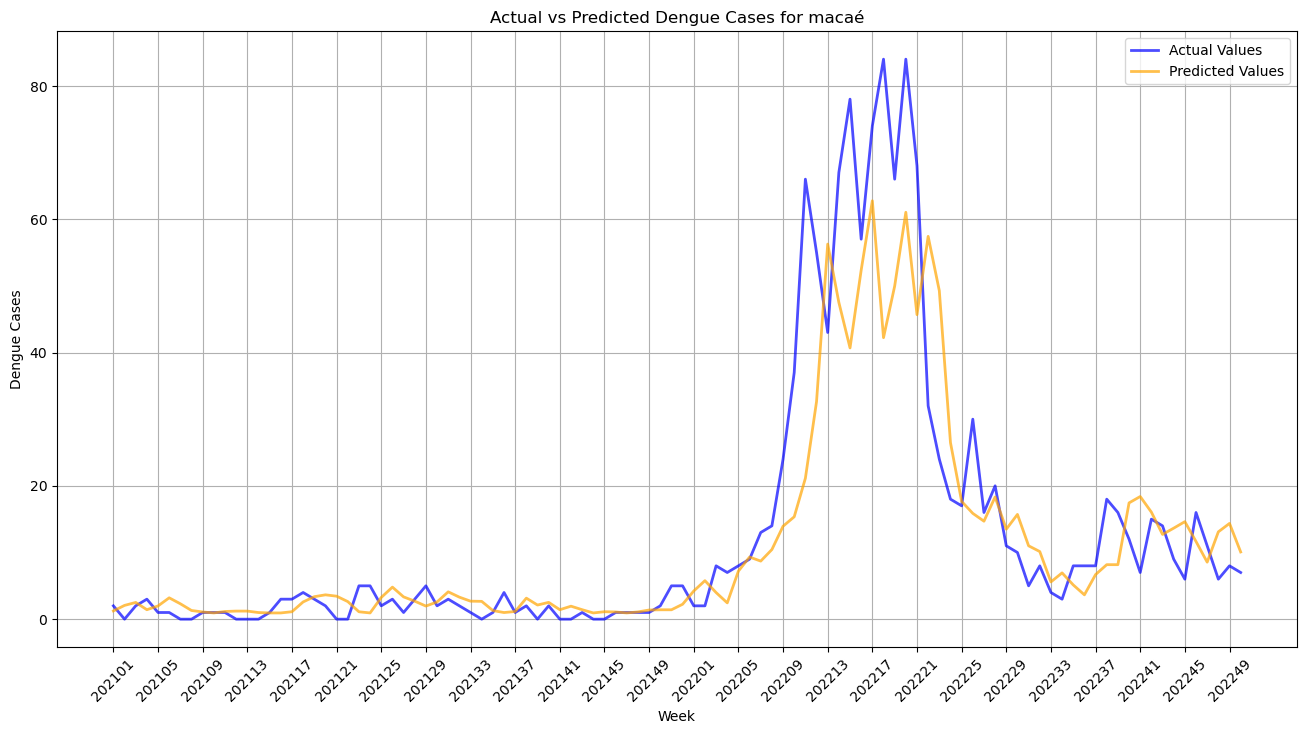


City: magé, RMSE: 1.7913047919389984


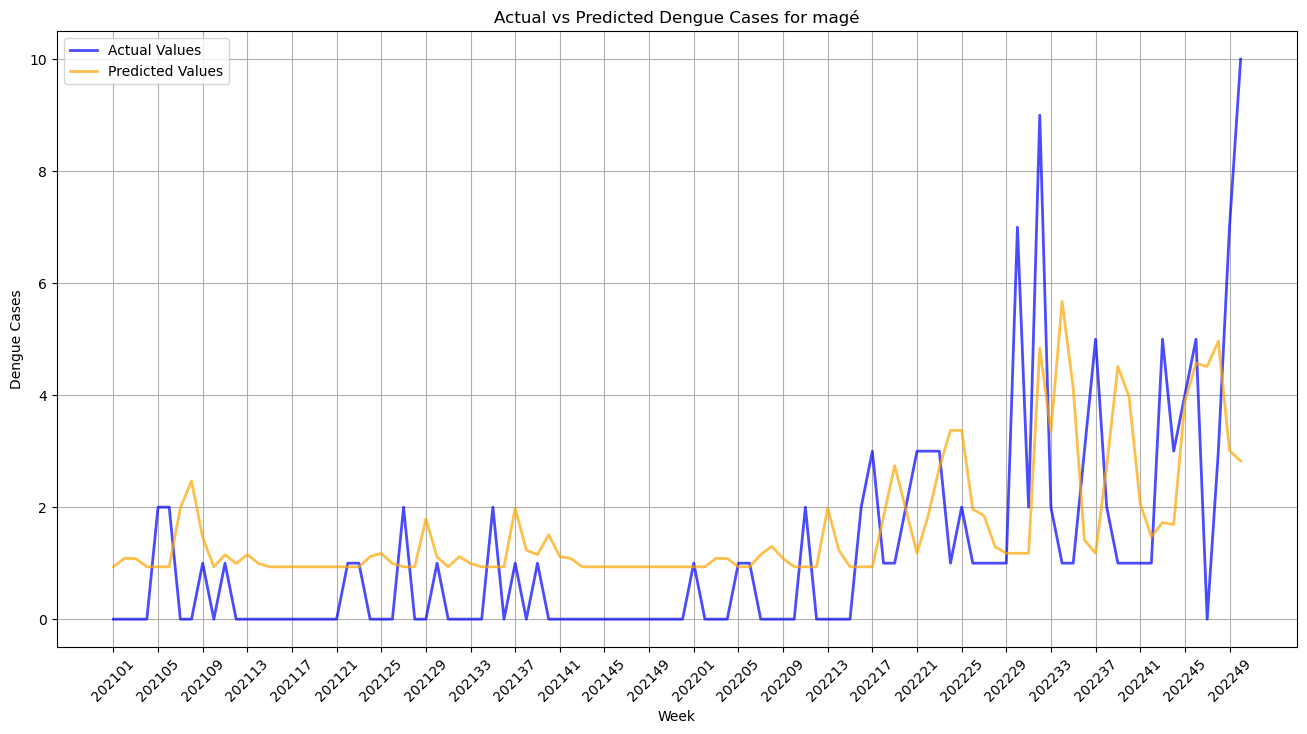


City: nova friburgo, RMSE: 5.033141749621866


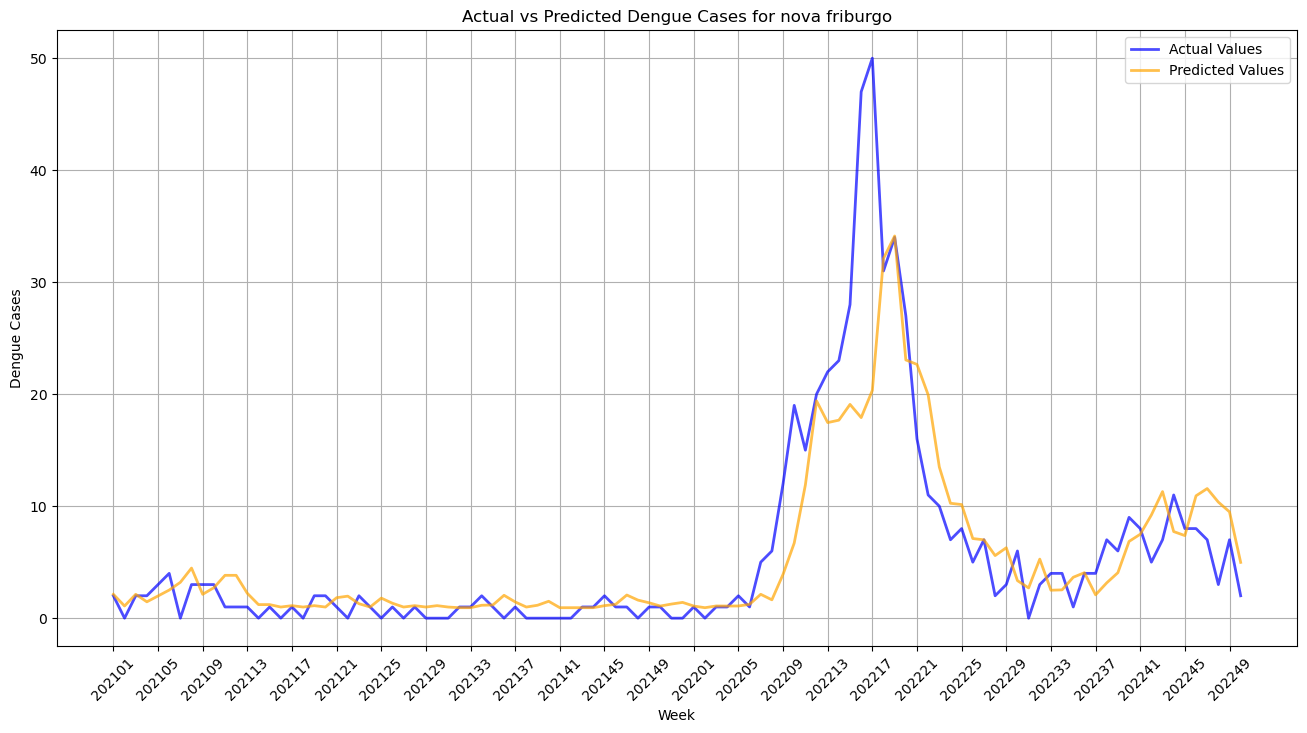


City: nova iguaçu, RMSE: 2.7092459549204757


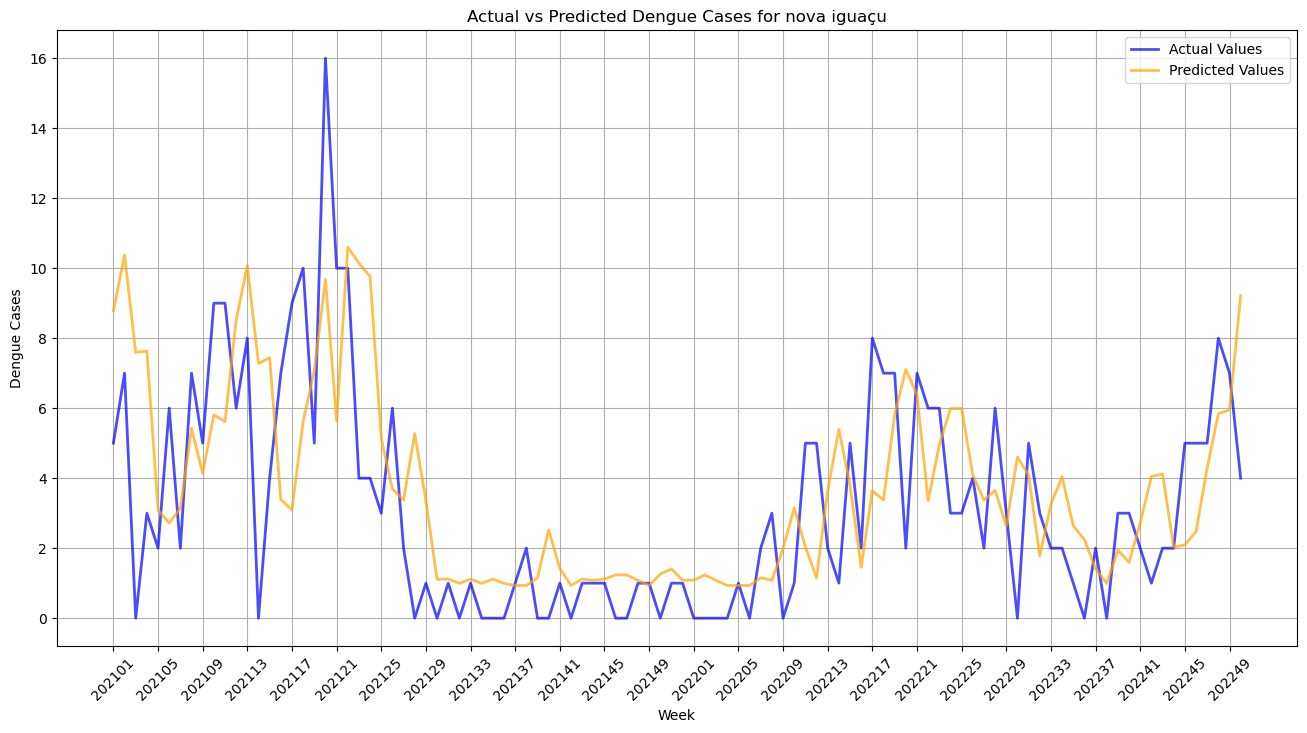


City: paraty, RMSE: 6.795173146232822


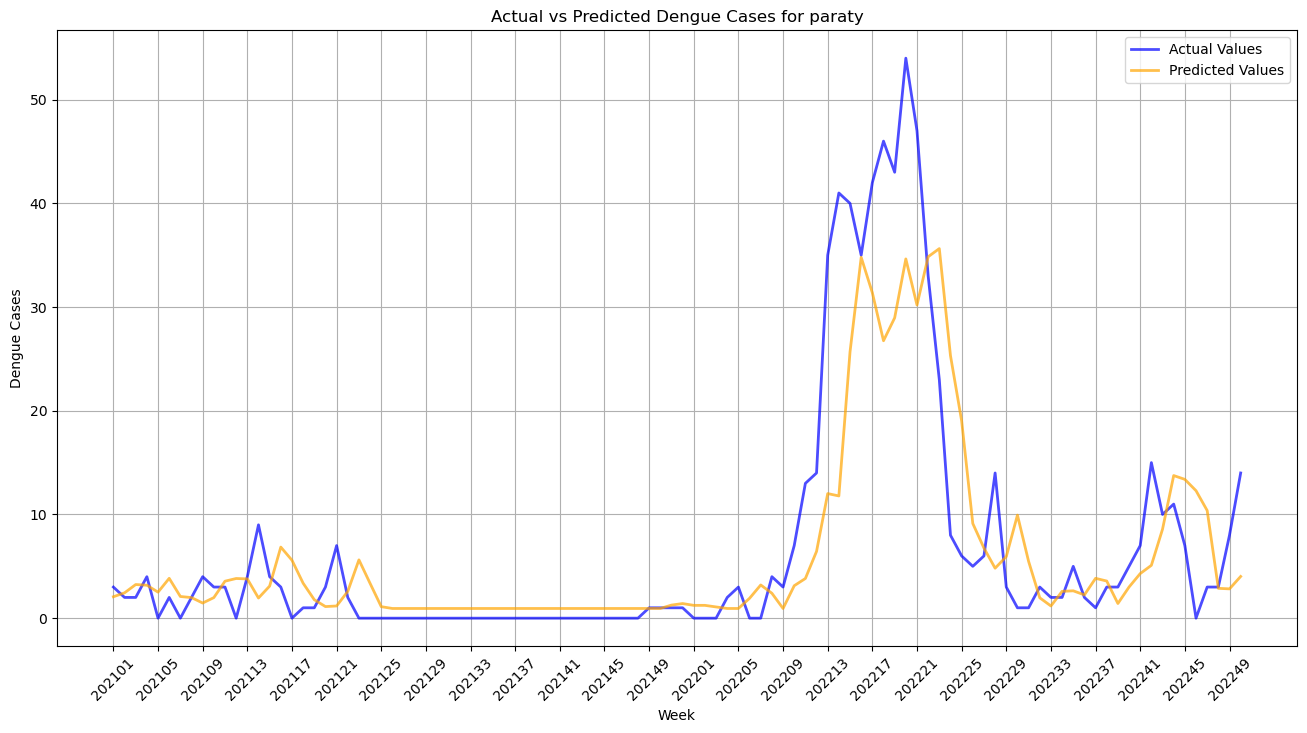


City: petrópolis, RMSE: 1.8981840888446875


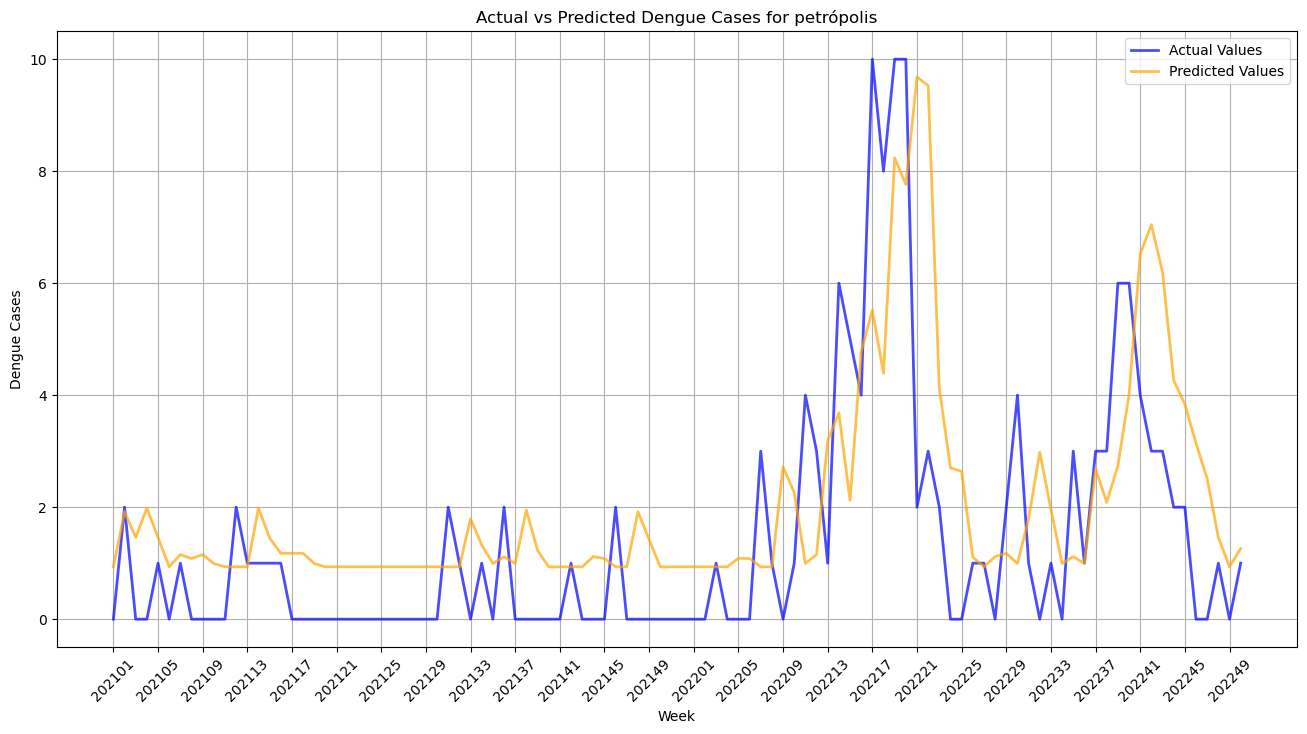


City: piraí, RMSE: 2.297388926670947


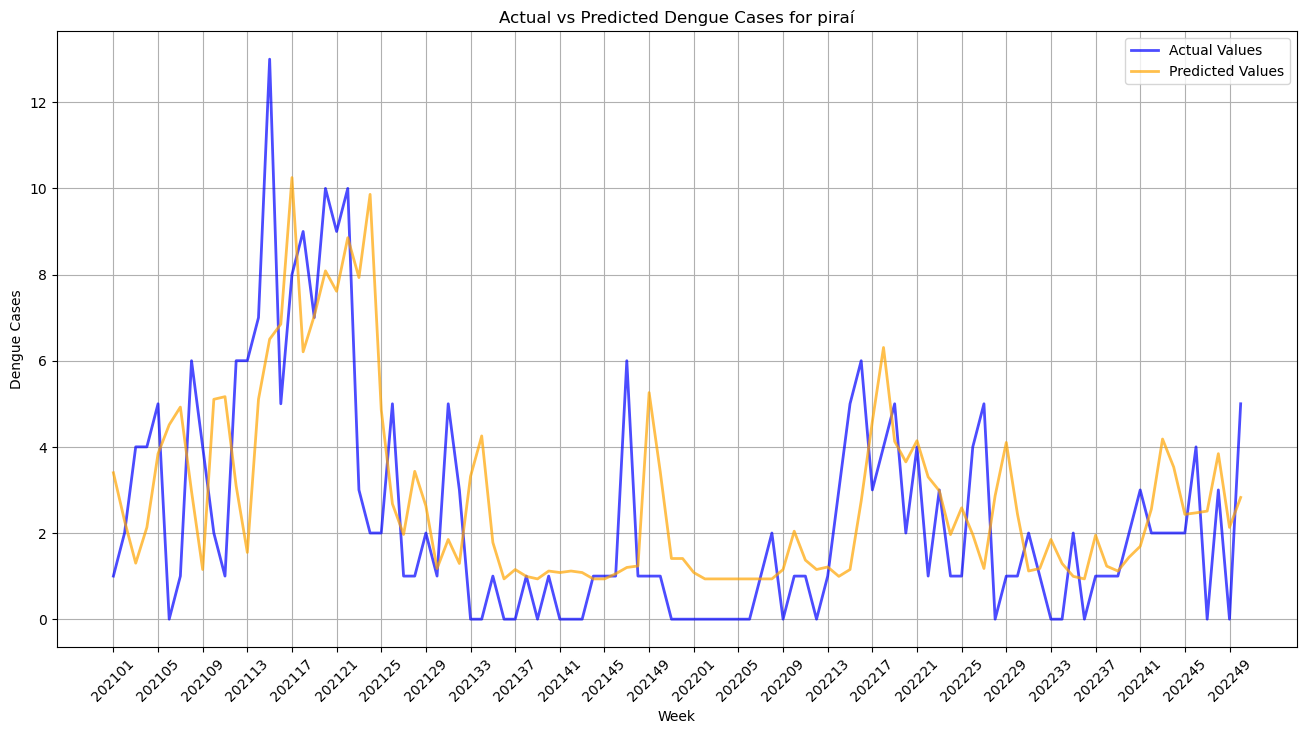


City: porciúncula, RMSE: 3.7664842004844026


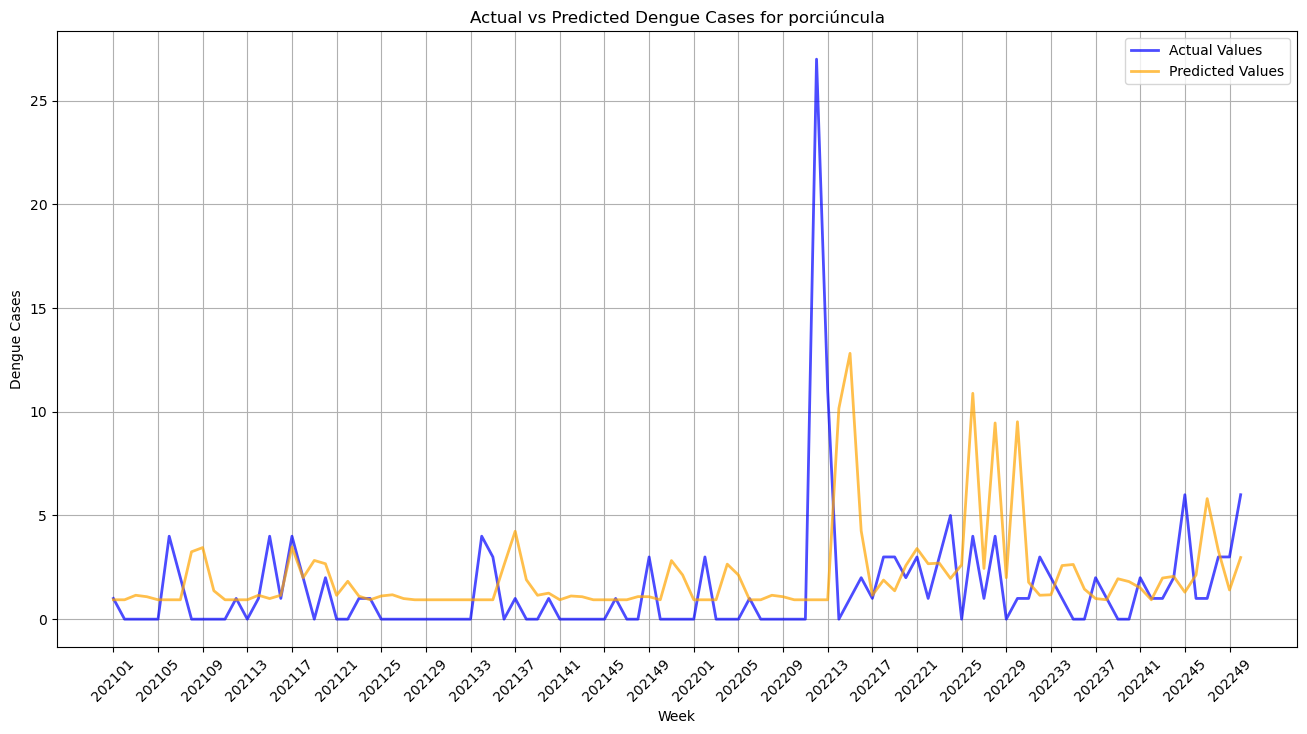


City: quatis, RMSE: 2.580321394074557


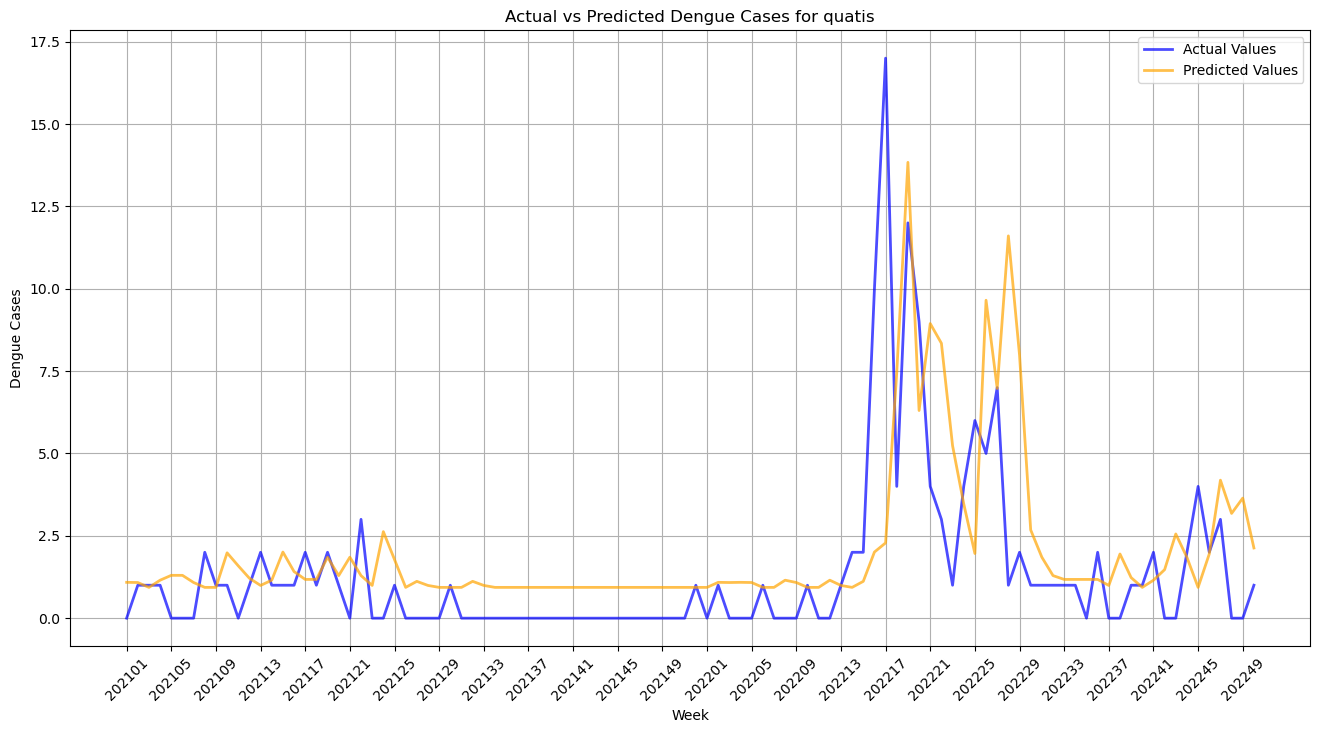


City: quissamã, RMSE: 3.484389019939051


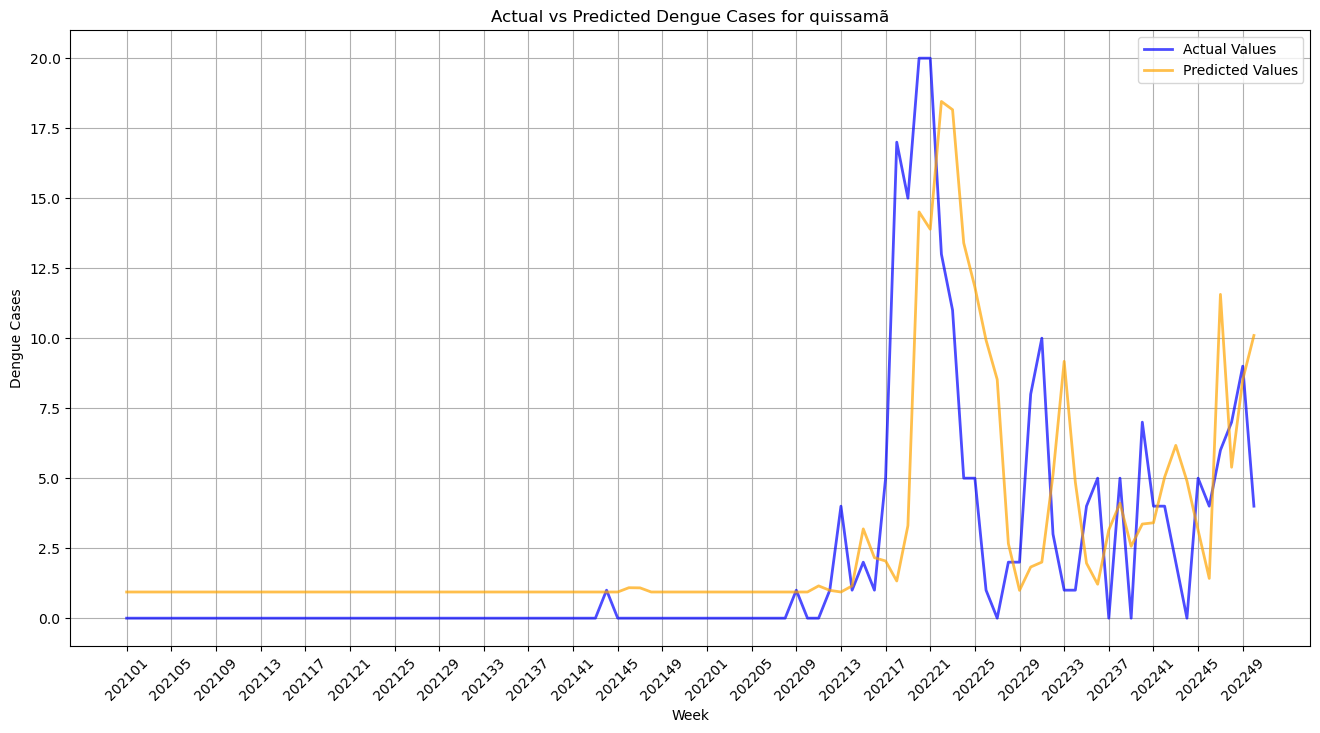


City: resende, RMSE: 10.219149086491335


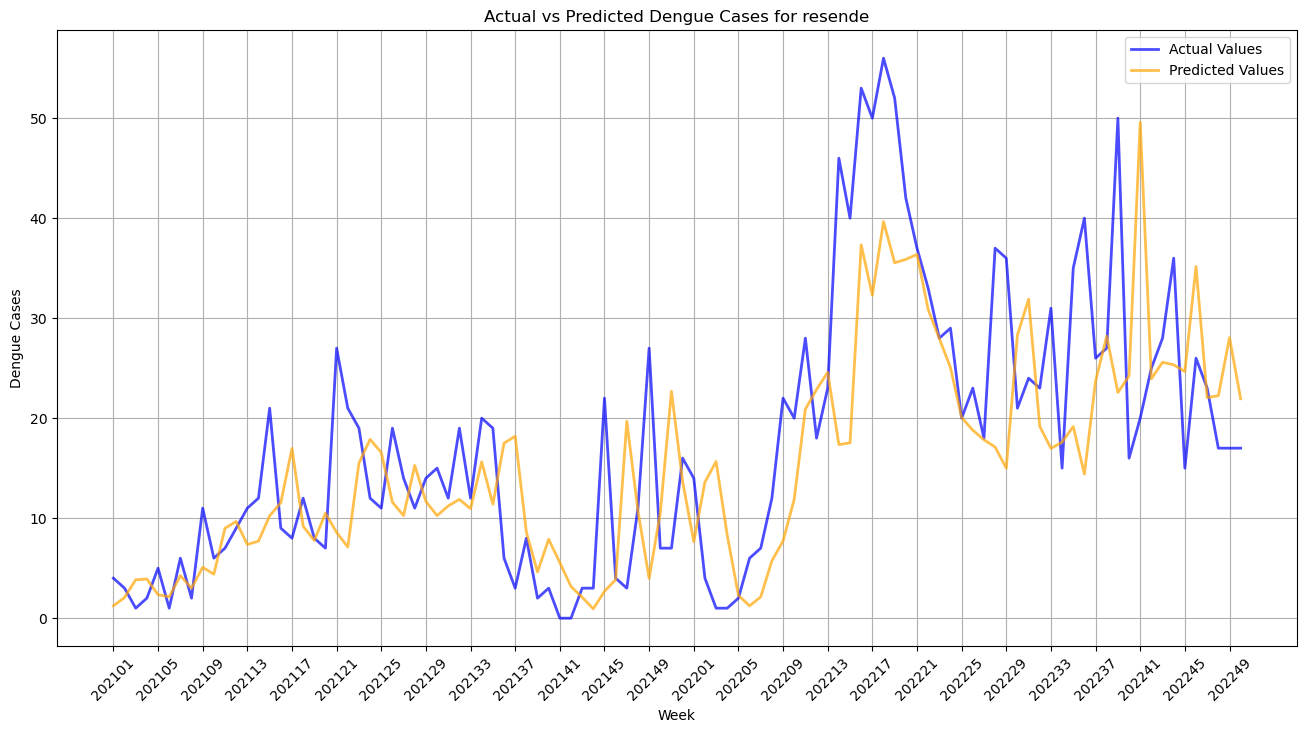


City: rio das ostras, RMSE: 8.272642093723208


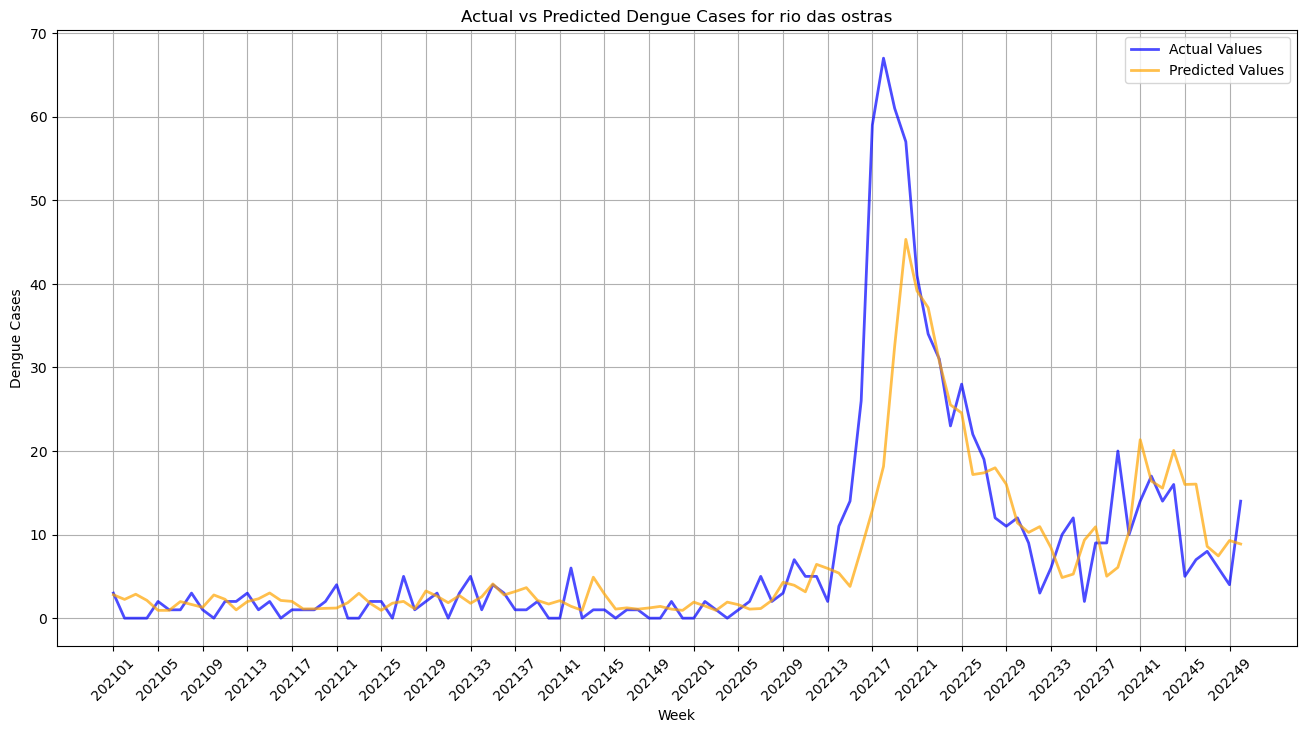


City: rio de janeiro, RMSE: 43.28012646583344


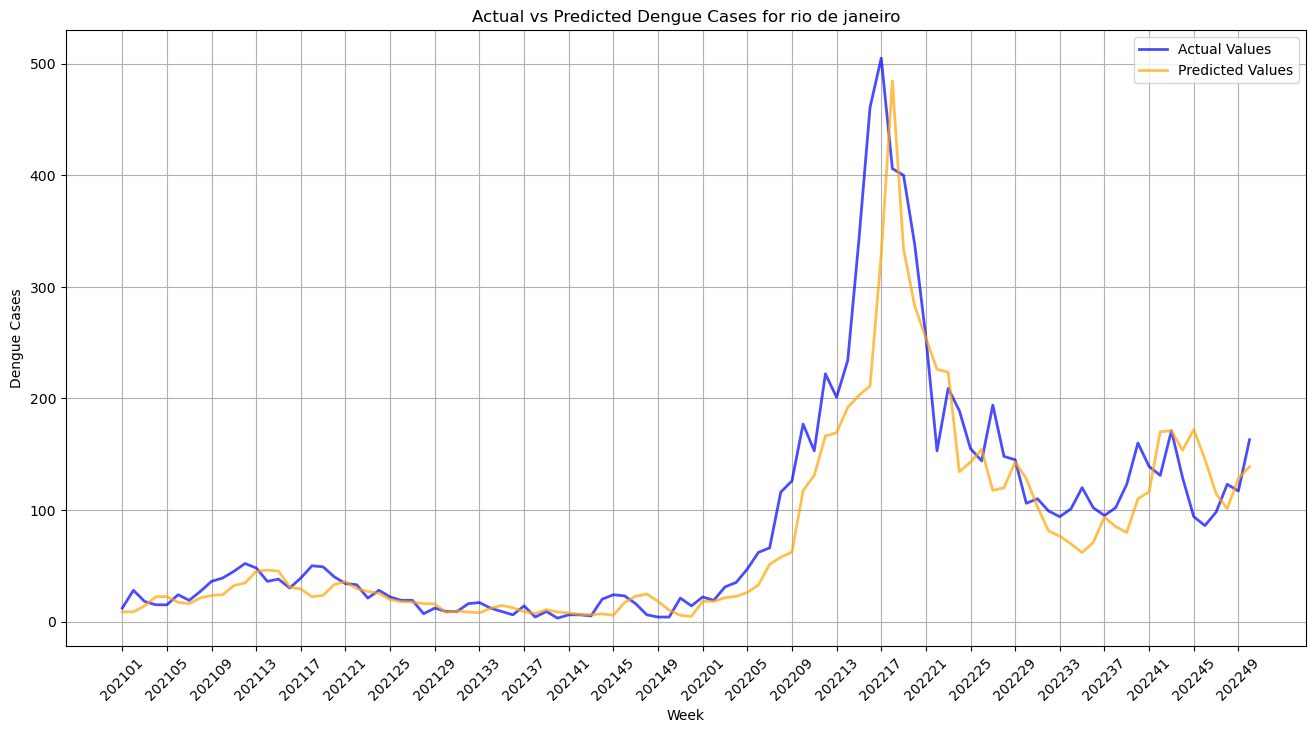


City: santo antônio de pádua, RMSE: 5.440480966657374


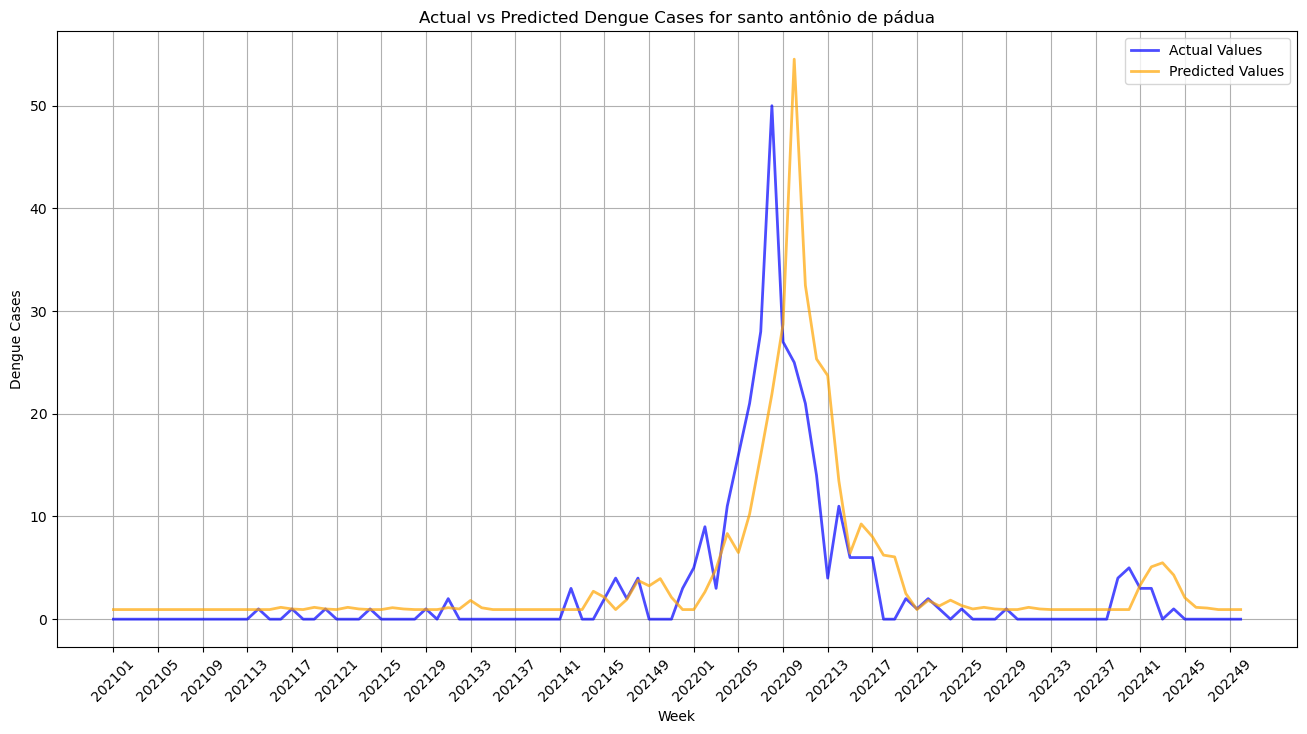


City: são gonçalo, RMSE: 2.4571191182157293


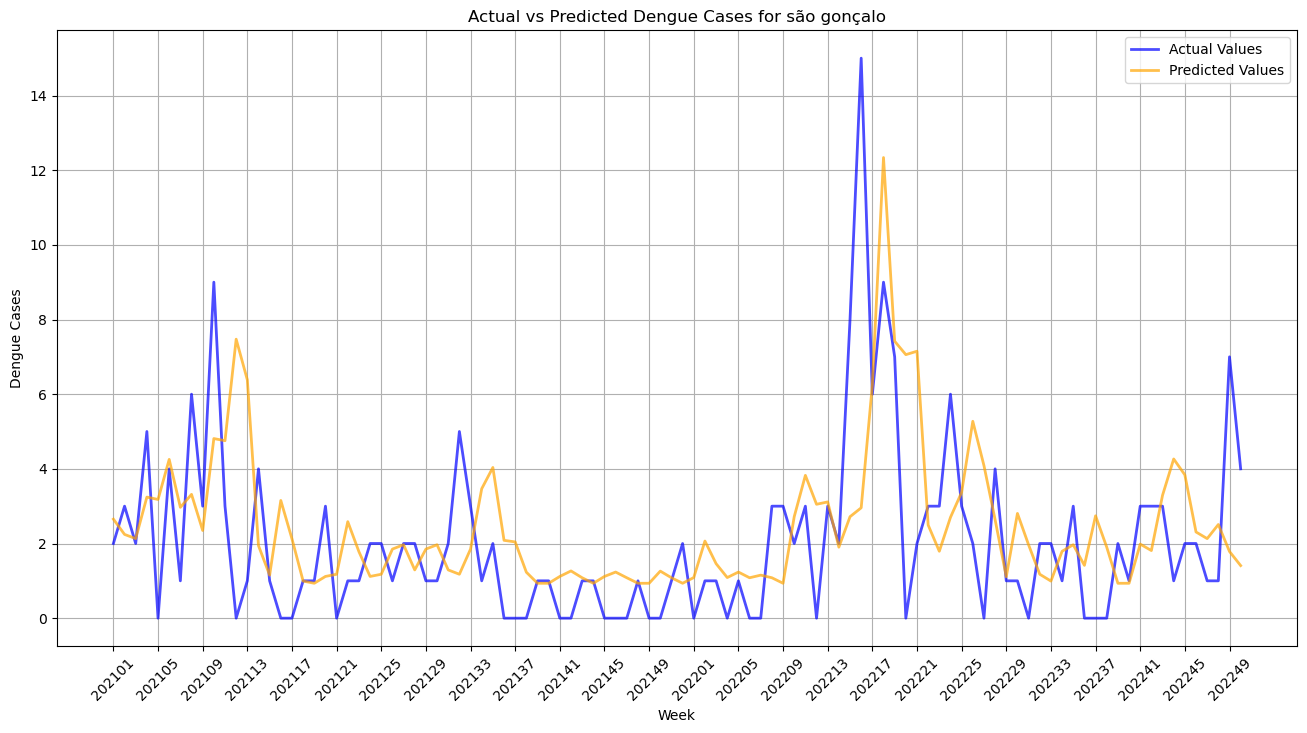


City: são joão de meriti, RMSE: 2.5329948136863014


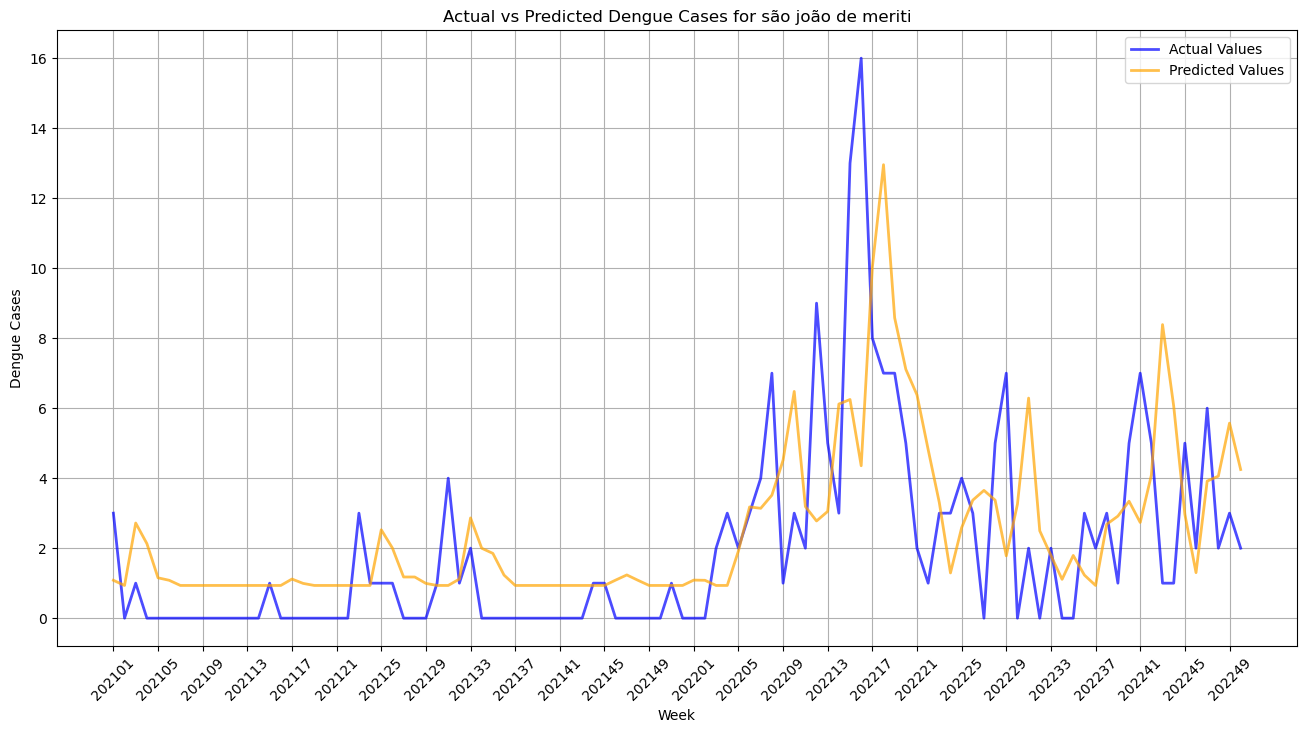


City: são pedro da aldeia, RMSE: 1.8905737328565624


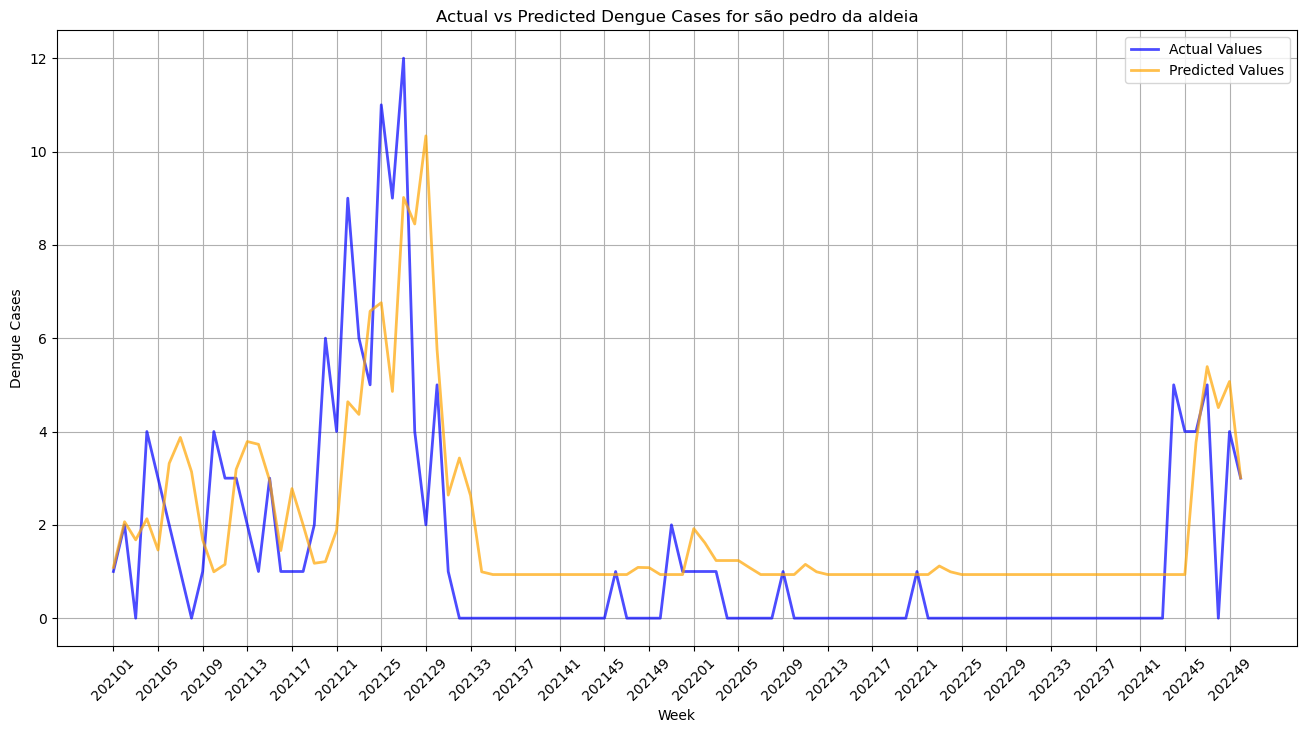


City: saquarema, RMSE: 4.4061312888176


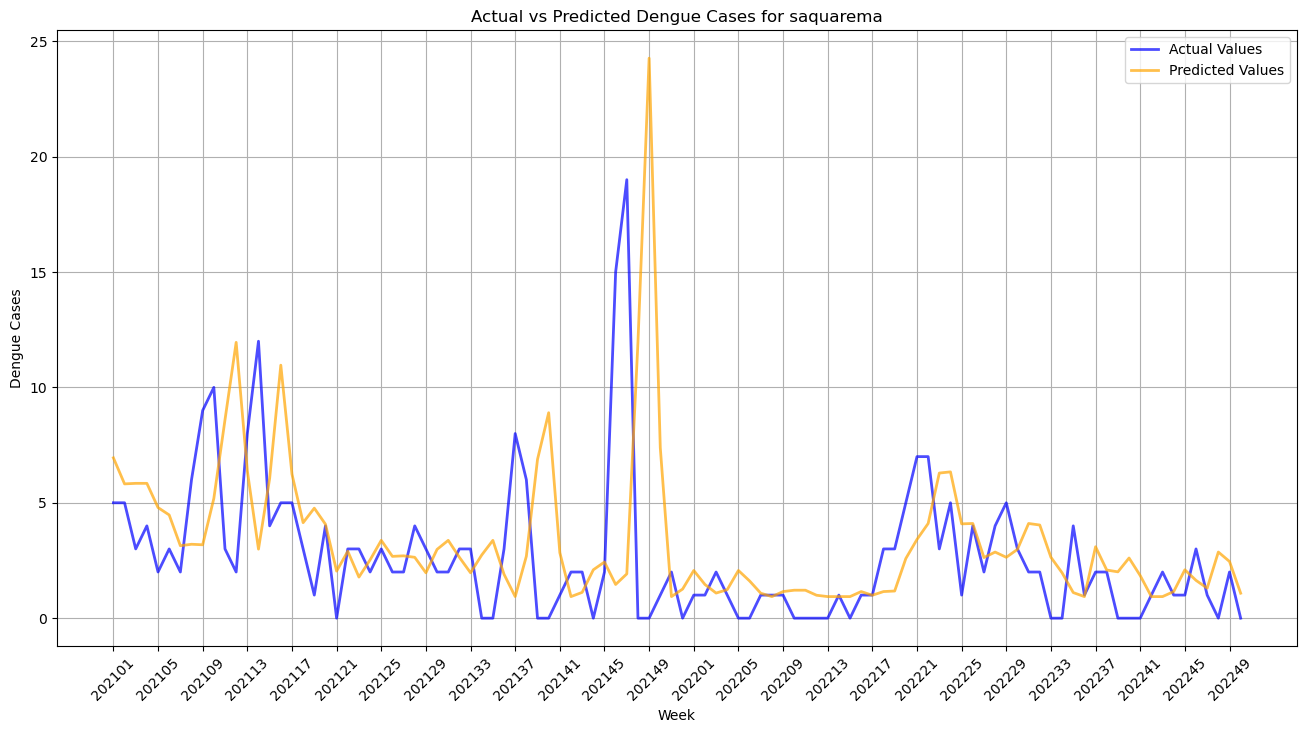


City: seropédica, RMSE: 3.491609621497789


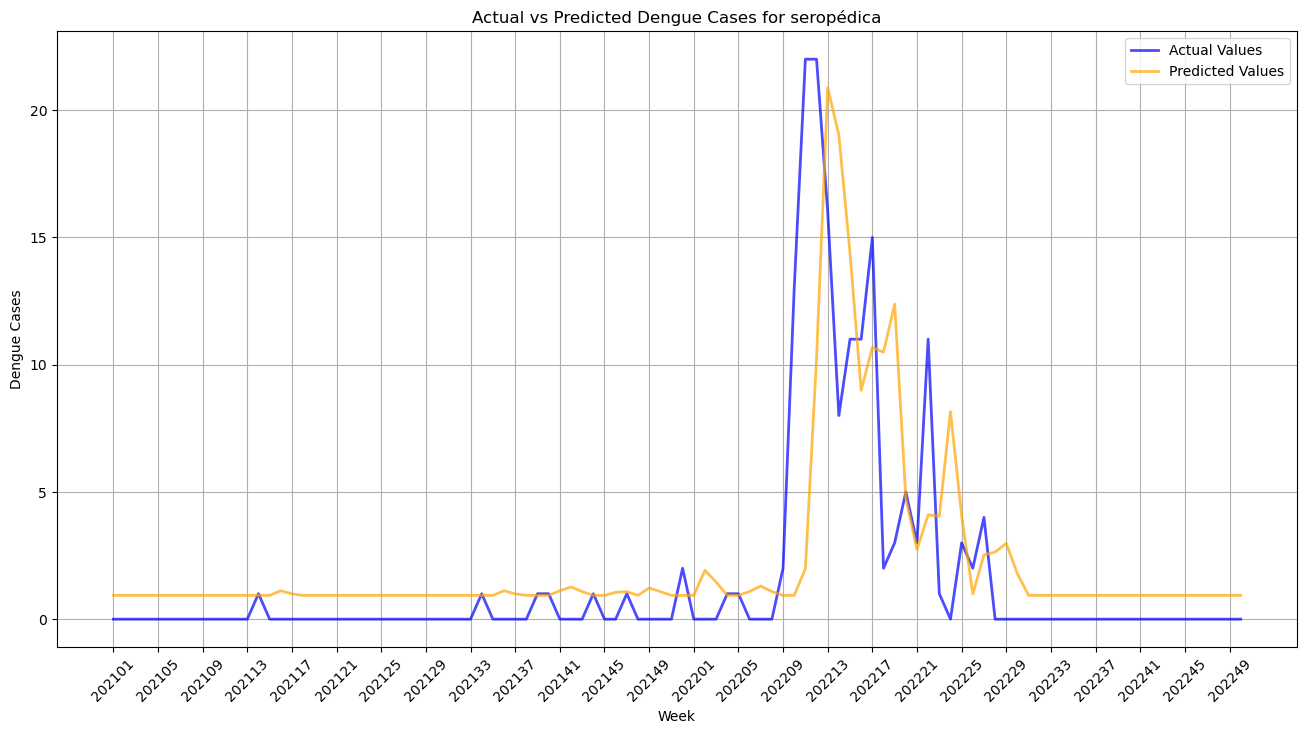


City: valença, RMSE: 2.621002110845328


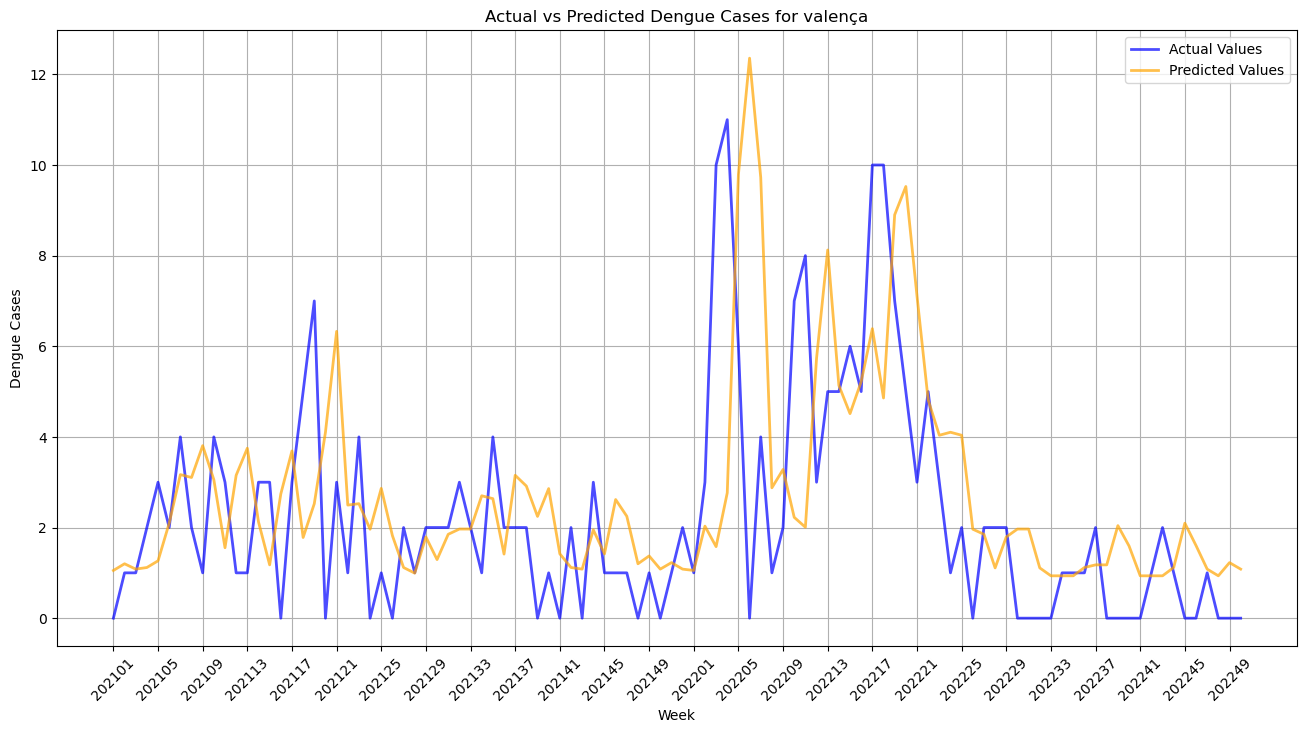


City: vassouras, RMSE: 2.234580856481688


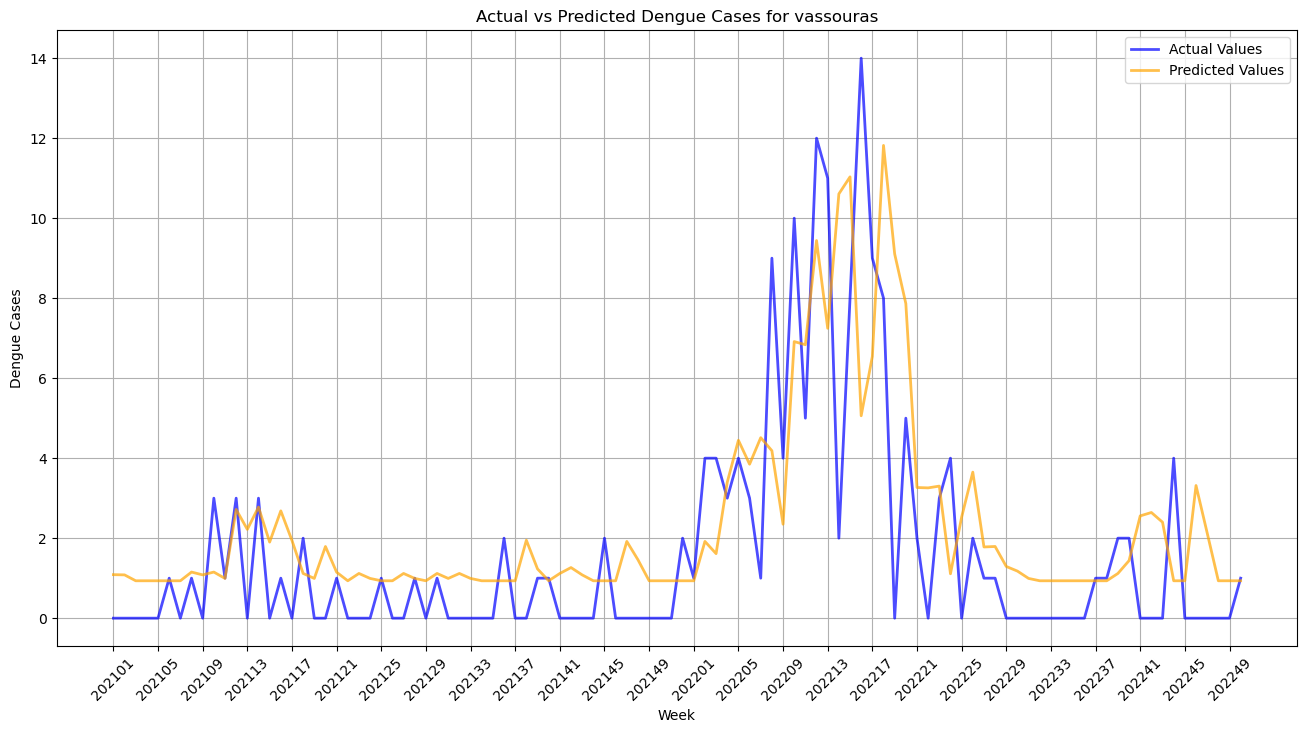


City: volta redonda, RMSE: 3.4760373302868106


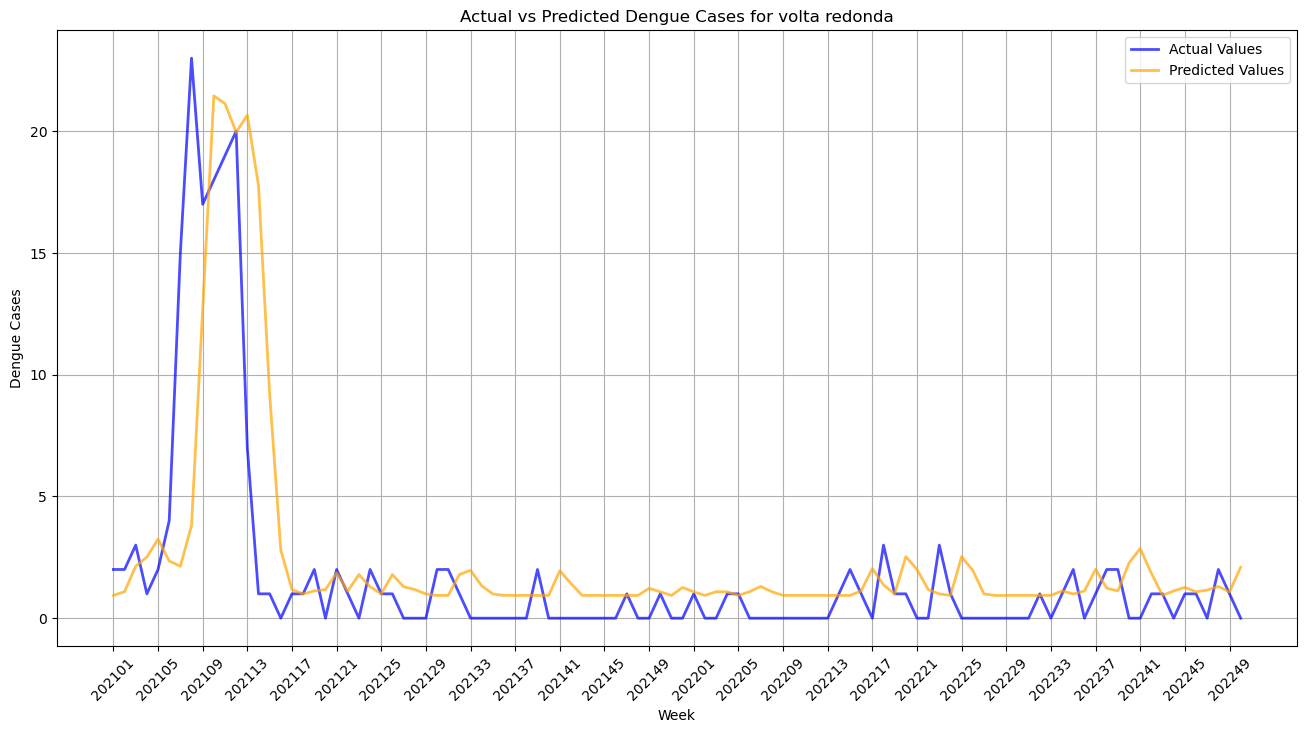

In [15]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

for city, indices in city_index_map.items():
    y_actual_city = y_actual[indices]
    y_pred_city = y_pred[indices]
    weeks_city = test_data.loc[indices, 'week'].astype(str)

    if np.max(y_actual_city) < 10:
        continue
    

    rmse_city = np.sqrt(mean_squared_error(y_actual_city, y_pred_city))
    print(f'\nCity: {city}, RMSE: {rmse_city}')
    plt.figure(figsize=(16, 8))
    plt.plot(weeks_city, y_actual_city, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
    plt.plot(weeks_city, y_pred_city, label='Predicted Values', color='orange', alpha=0.7, linewidth=2)

    plt.xlabel('Week')
    plt.ylabel('Dengue Cases')
    plt.title(f'Actual vs Predicted Dengue Cases for {city}')
    plt.legend()
    plt.grid(True)
    plt.xticks(weeks_city[::4], rotation=45)
    plt.show()